In [1]:
import numpy as np
import torch
from torch import nn  
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
path.insert(1,  root+'/work')
import work.AM4std2_lw_cs_LiH4Relu_EN.train_script01 as lwcsafen
import work.AM4std2_lw_cs_LiH4Relu_EY.train_script01 as lwcsafey 
import work.AM4std2_lw_all_LiH4Relu_EN.train_script01 as lwafen
import work.AM4std2_lw_all_LiH4Relu_EY.train_script01 as lwafey 

In [3]:
from get_data_lw_AM4_std import get_data_lw_AM4
######################################################
# common functions to split the training and test data
from NNRTMC_utils import  split_train_test_sample, \
draw_batches, data_std_normalization, print_key_results, return_exp_dir
    
from diag_utils import batch_index_sta_end, pred_NN_batch,\
create_6tiles_lw,regrid_6tile2latlon

In [4]:
if __name__ == '__main__': 
    torch.cuda.set_device(0) # select gpu_id, default 0 means the first GPU
    device = f'cuda:{torch.cuda.current_device()}'
    # device = 'cpu'
    ######################################################
    # set exp name and runs
    Exp_name = [
        'AM4std2_lw_cs_LiH4Relu_EN',
        'AM4std2_lw_cs_LiH4Relu_EY',
        'AM4std2_lw_all_LiH4Relu_EN'  ,
        'AM4std2_lw_all_LiH4Relu_EY'  ,
    ]
    Exp_name_model_dict = {
        'AM4std2_lw_cs_LiH4Relu_EN'   : lwcsafen,
        'AM4std2_lw_cs_LiH4Relu_EY'   : lwcsafey,
        'AM4std2_lw_all_LiH4Relu_EN'  : lwafen,
        'AM4std2_lw_all_LiH4Relu_EY'  : lwafey,
    }
    sky_cond = {
        'AM4std2_lw_cs_LiH4Relu_EN'   : 'cs',
        'AM4std2_lw_cs_LiH4Relu_EY'   : 'cs',
        'AM4std2_lw_all_LiH4Relu_EN'  : 'all',
        'AM4std2_lw_all_LiH4Relu_EY'  : 'all',
    }
    work_dir = root+'/work/' 
    # file list AM4 runs 
    filelist = [f'/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/'+
            f'HISTORY/20000101.atmos_8xdaily.tile{_}.nc' for _ in range(1,7)] 
    hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
    A_k = hybrid_p_sigma_para.ak.values[None,:]
    B_k = hybrid_p_sigma_para.bk.values[None,:] 

In [5]:
plt.rcParams['font.size'] = '6'

In [6]:
month_sel = None
day_sel = [15,18,21,24,27]
# month_sel = [1]
# day_sel = [15]

In [7]:
%%time 
NN_model = {}
ds_regrid = {}

for mo in Exp_name:
    ######################################################
    # load restart file
    run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
    # load restart file
#     PATH_last =  exp_dir+f'/restart.{run_num-1:02d}.pth'
#     restart_data = torch.load(PATH_last)  # load exist results and restart training
#     print(f'load: {PATH_last}')
#     # read training dataset, nor_para, model parameteres
#     nor_para = restart_data['nor_para']
#     model_state_dict = restart_data['model_state_dict']
#     # read data
#     input_array_ori, output_array_ori, ds_coords = \
#     get_data_lw_AM4(filelist, condition=sky_cond[mo], 
#                     month_sel = month_sel, day_sel = day_sel, return_coords=True) 
#     # initialize model 
#     NN_model[mo] = Exp_name_model_dict[mo].NNRTMC_NN(device, nor_para, A_k, B_k, input_array_ori.shape[1],model_state_dict)  
 
#     # normalize data via saved nor_para in restart file
#     nor_para, input_array, output_array   = data_std_normalization(input_array_ori, output_array_ori, nor_para)
    
#     # try NN on test dataset  
#     predi, eng_err = pred_NN_batch(input_array, output_array, NN_model[mo], nor_para, device)
#     error = predi - output_array_ori
#     predi[:,3:] = predi[:,3:]*86400 # HR K/s >> K/day
#     error[:,3:] = error[:,3:]*86400 # HR K/s >> K/day
#     # create 6-tile files for output and regrid 
#     NN_output_name = 'NN_20000101.fluxes' 
#     subprocess.run([f'mkdir -p {exp_dir}/NN_pred'], shell=True, check=True)
#     var_list = create_6tiles_lw(ds_coords, predi, error, eng_err,  exp_dir, NN_output_name)
#     del predi, error, eng_err
#     regrid_file_path = regrid_6tile2latlon(var_list,exp_dir,root, NN_output_name)
    regrid_file_path = exp_dir+f'/NN_pred/NN_20000101.fluxes.nc'
    print(regrid_file_path)
    # open regridded file
    with  xr.open_dataset(regrid_file_path) as ds:
        ds_regrid[mo] = ds.load().rename({'grid_yt':'lat', 'grid_xt':'lon'}) 


/tigress/cw55/work/2022_radi_nn/NN_AM4/work/AM4std2_lw_cs_LiH4Relu_EN/NN_pred/NN_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/NN_AM4/work/AM4std2_lw_cs_LiH4Relu_EY/NN_pred/NN_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/NN_AM4/work/AM4std2_lw_all_LiH4Relu_EN/NN_pred/NN_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/NN_AM4/work/AM4std2_lw_all_LiH4Relu_EY/NN_pred/NN_20000101.fluxes.nc
CPU times: user 2.93 s, sys: 13.7 s, total: 16.6 s
Wall time: 5min 38s


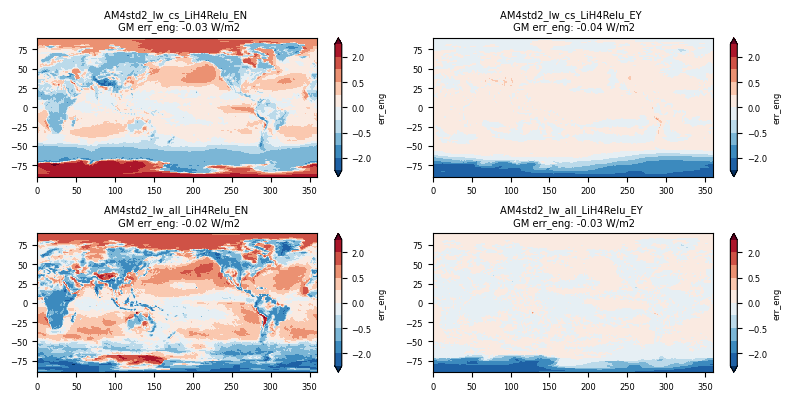

In [8]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(8,4),dpi=100)
axs = axs.flatten() 
for i, mo in enumerate(Exp_name):
    ds_plot = ds_regrid[mo]
    var_name = 'err_eng'
    level = np.array([-4,-2,-1,-0.5,-0.2,0,0.2,0.5,1,2,4 ])
    # level = np.arange(-5,5.1,0.5)
    # if sky_cond[mo] == 'af':  level = level*2
    ax=axs[i]
    da = ds_plot[var_name].mean('time')
    da.plot(ax=ax, levels=level, extend='both') 
    ax.set_title(f'{mo} \n GM err_eng: {global_mean_xarray(da).values:4.2f} W/m2') 
    ax.set(xlabel=None,ylabel=None)
    # plt.title(mo)
fig.tight_layout()

In [9]:
month_sel=[1,2,3,4,5,6,7,8,9,10,11,12]
day_sel=[15,18,21,24,27]

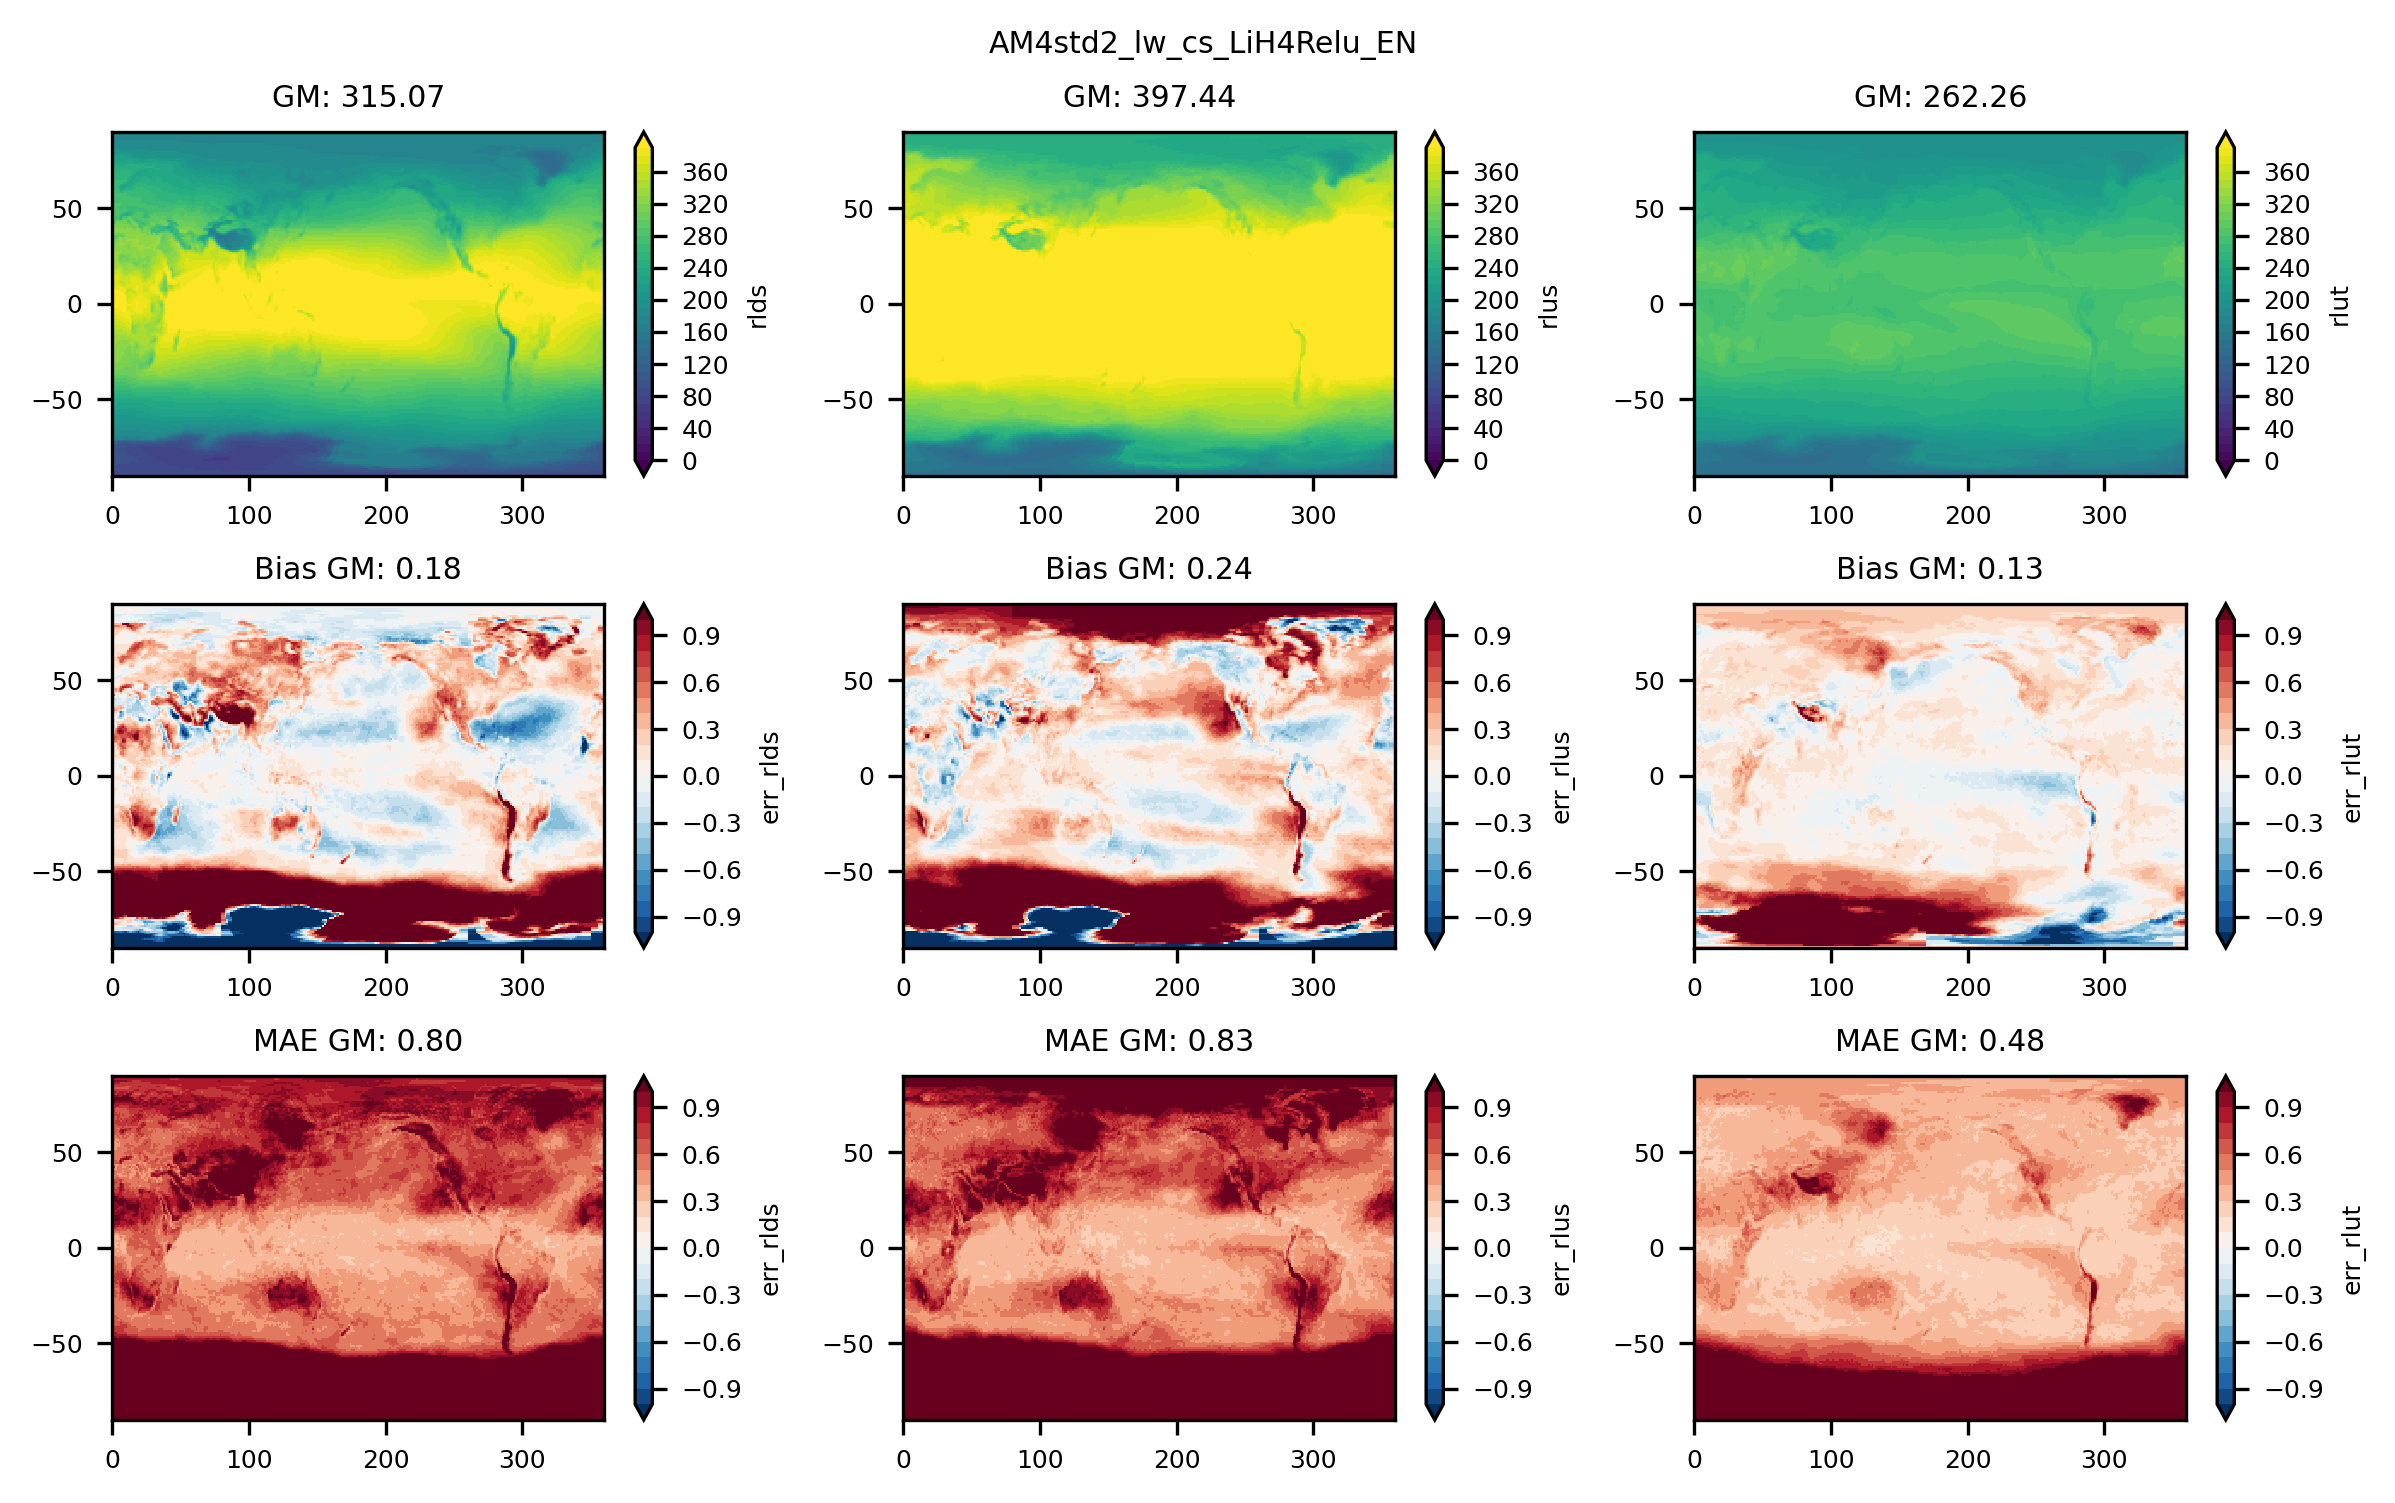

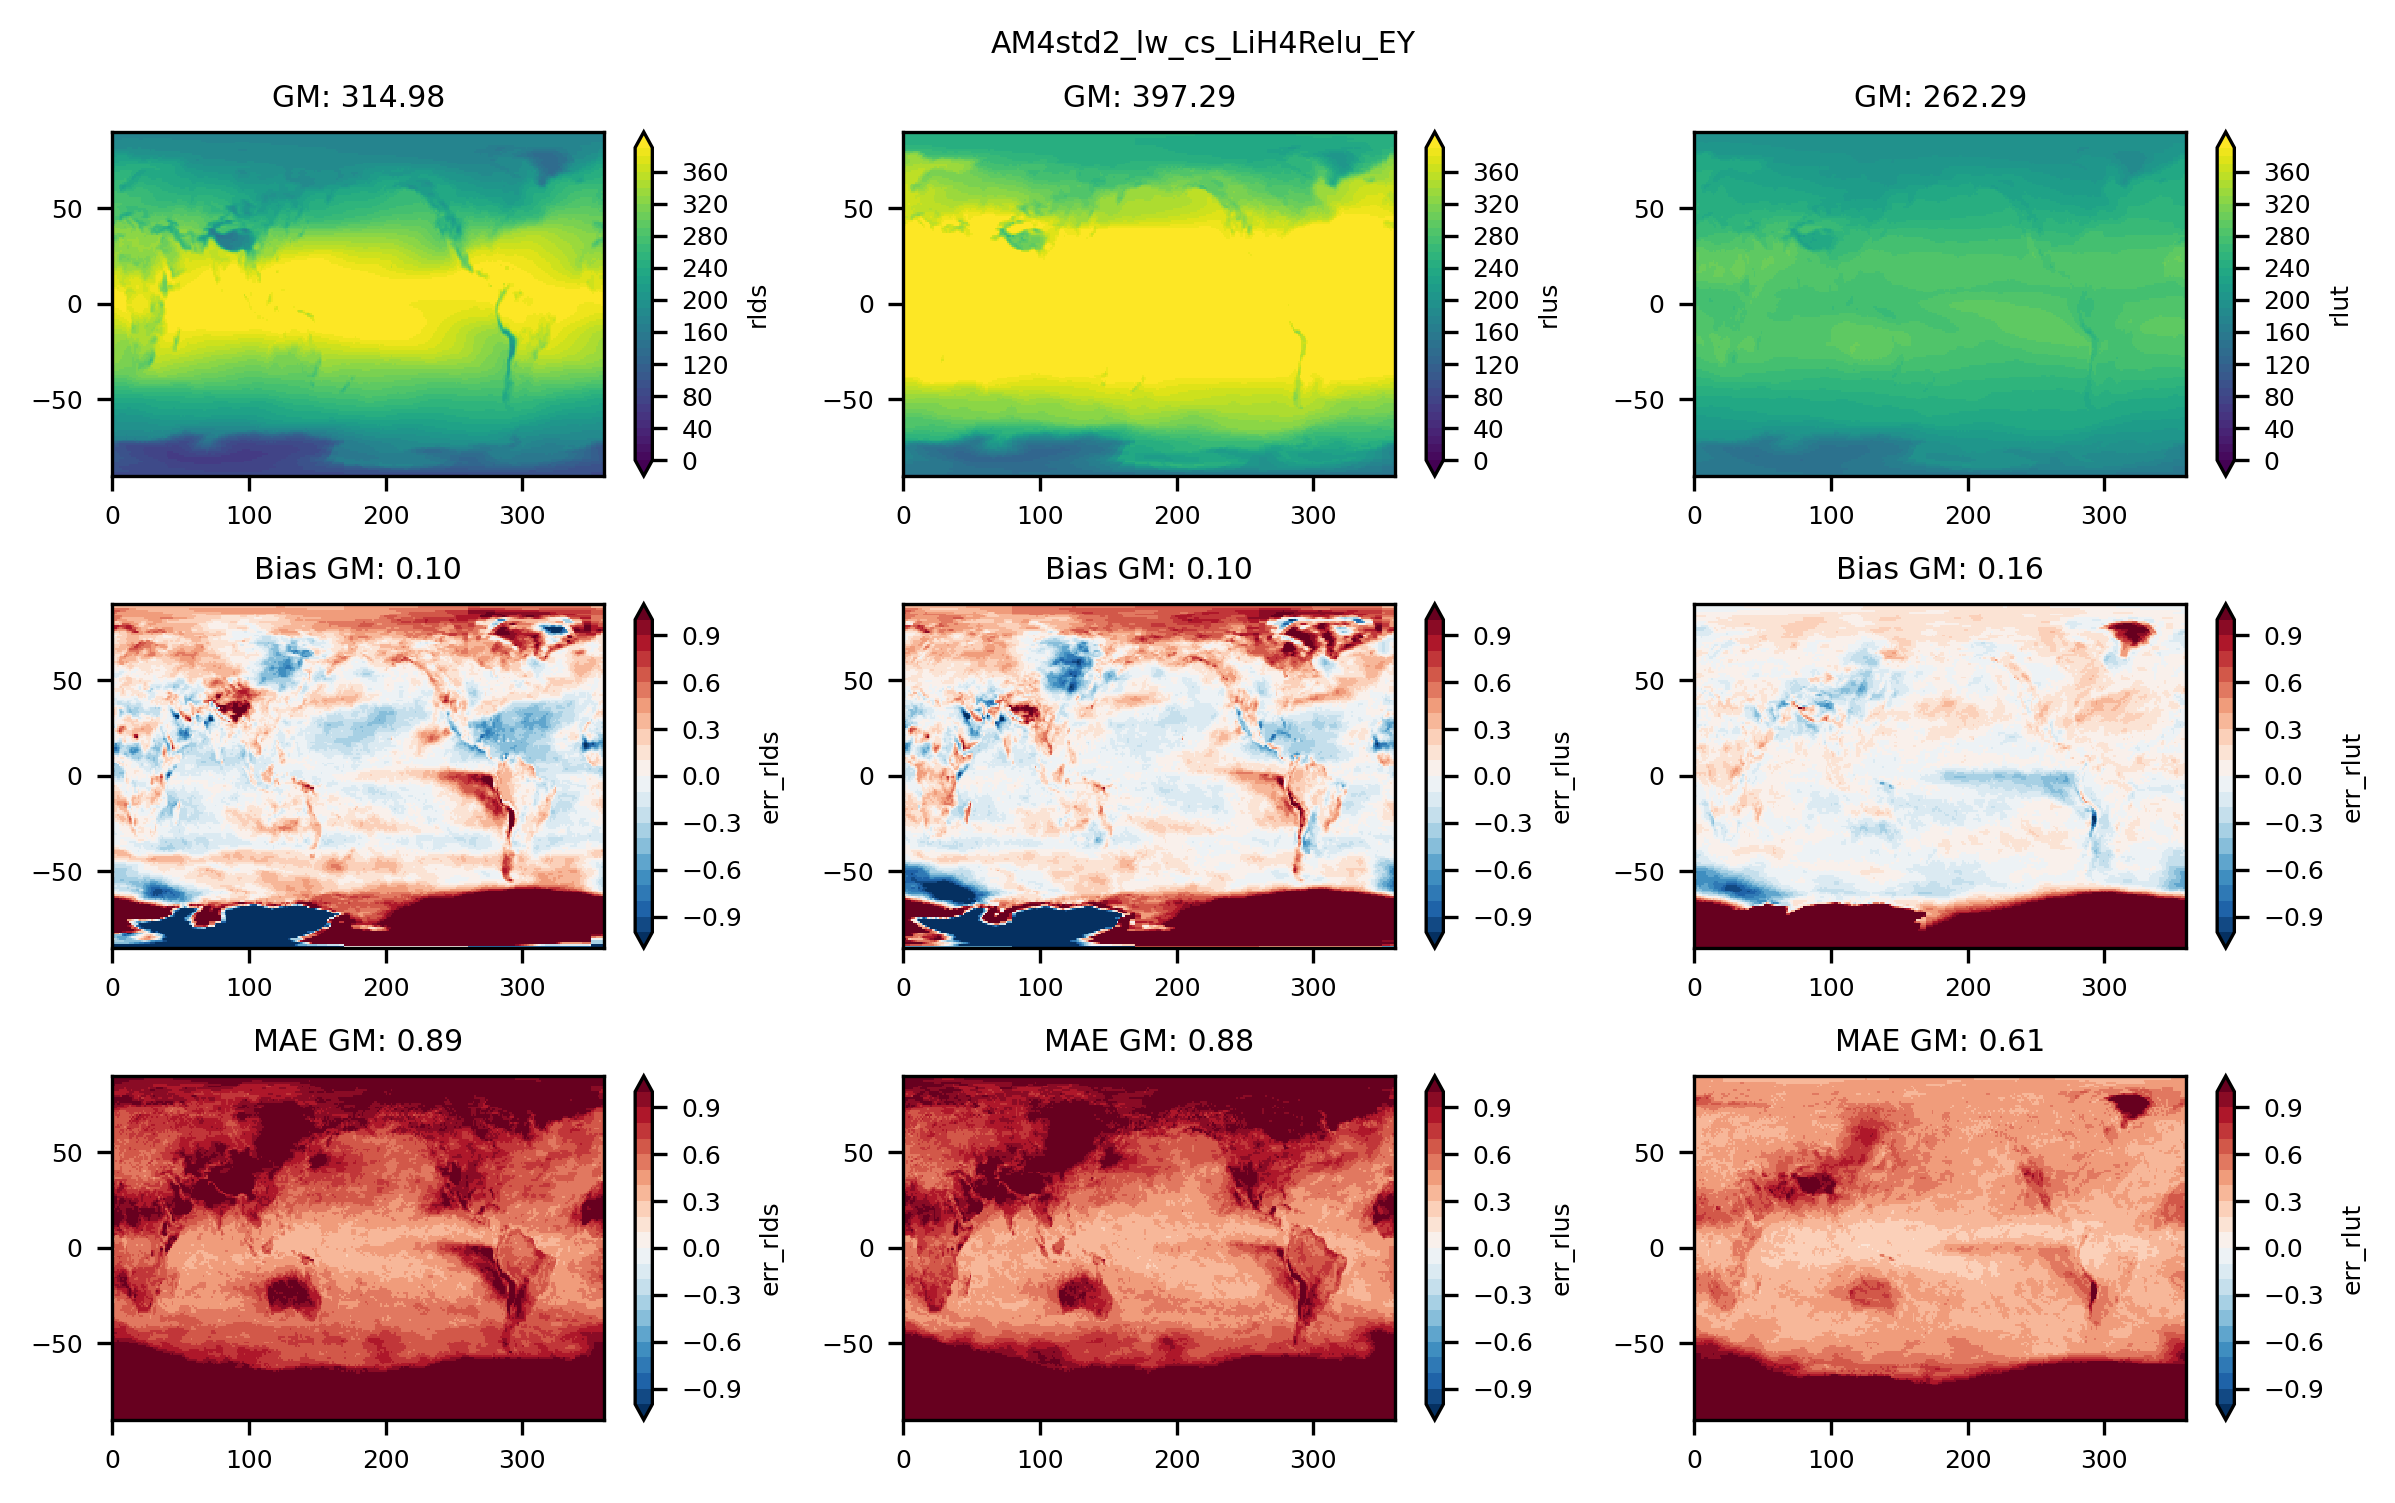

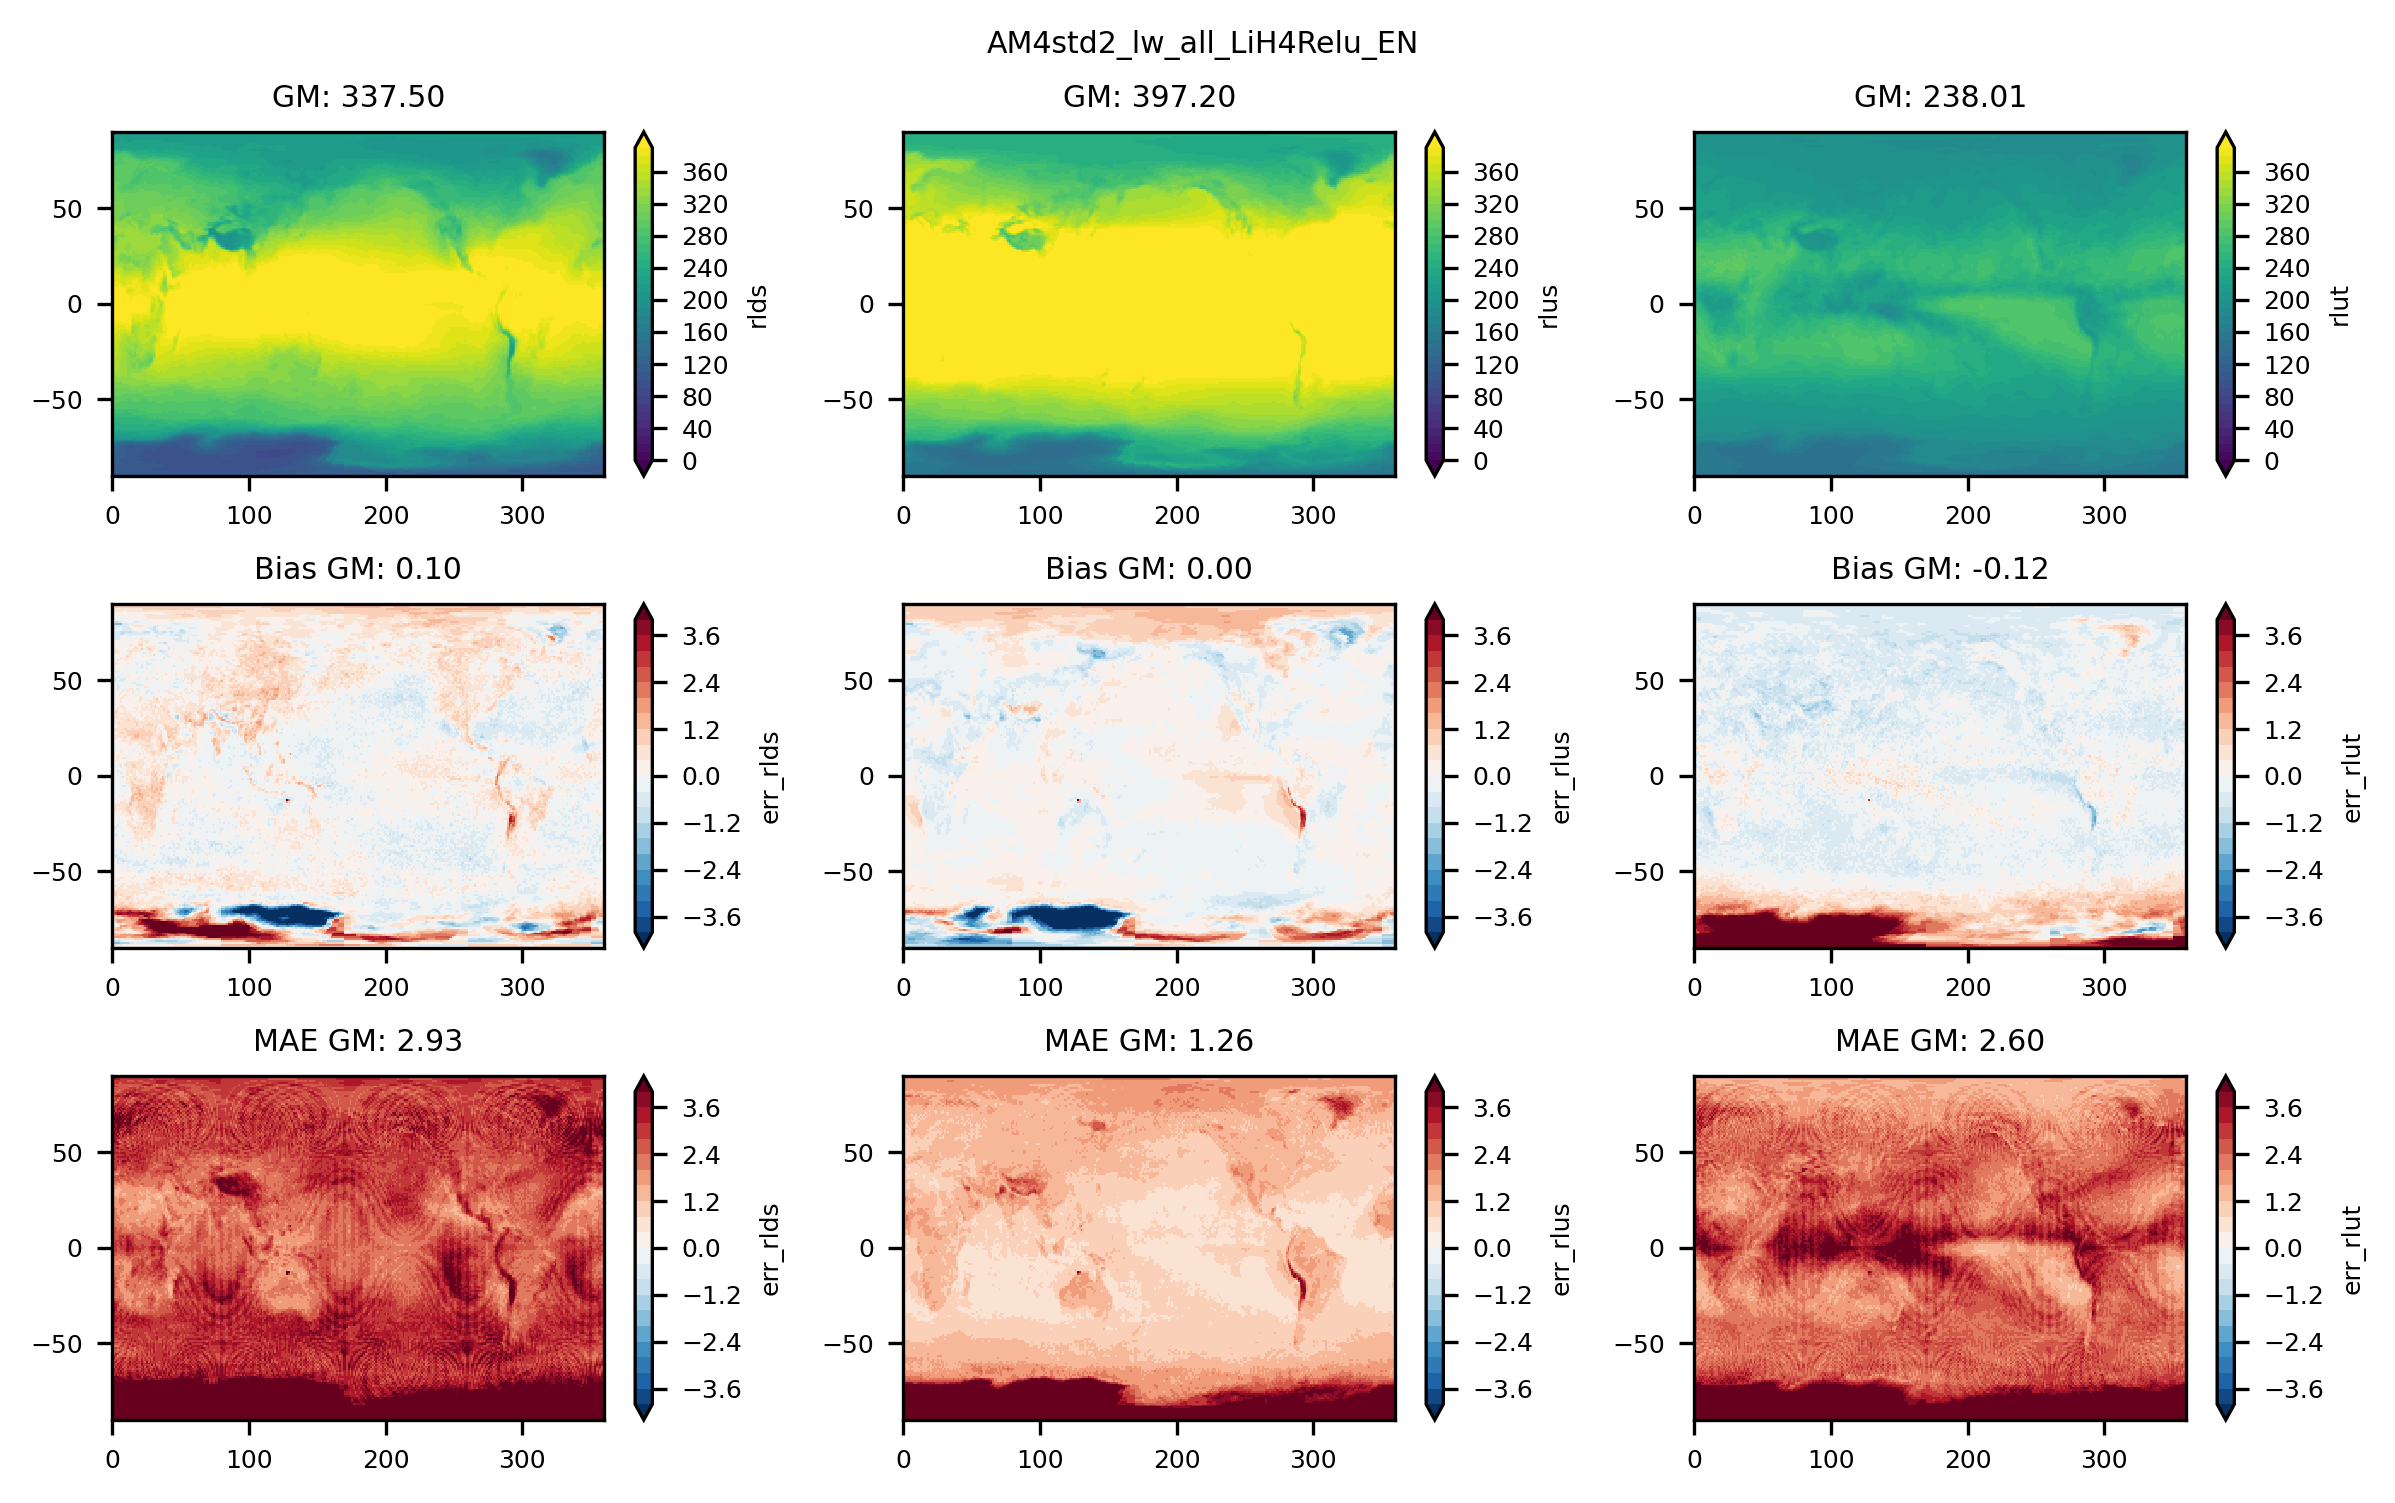

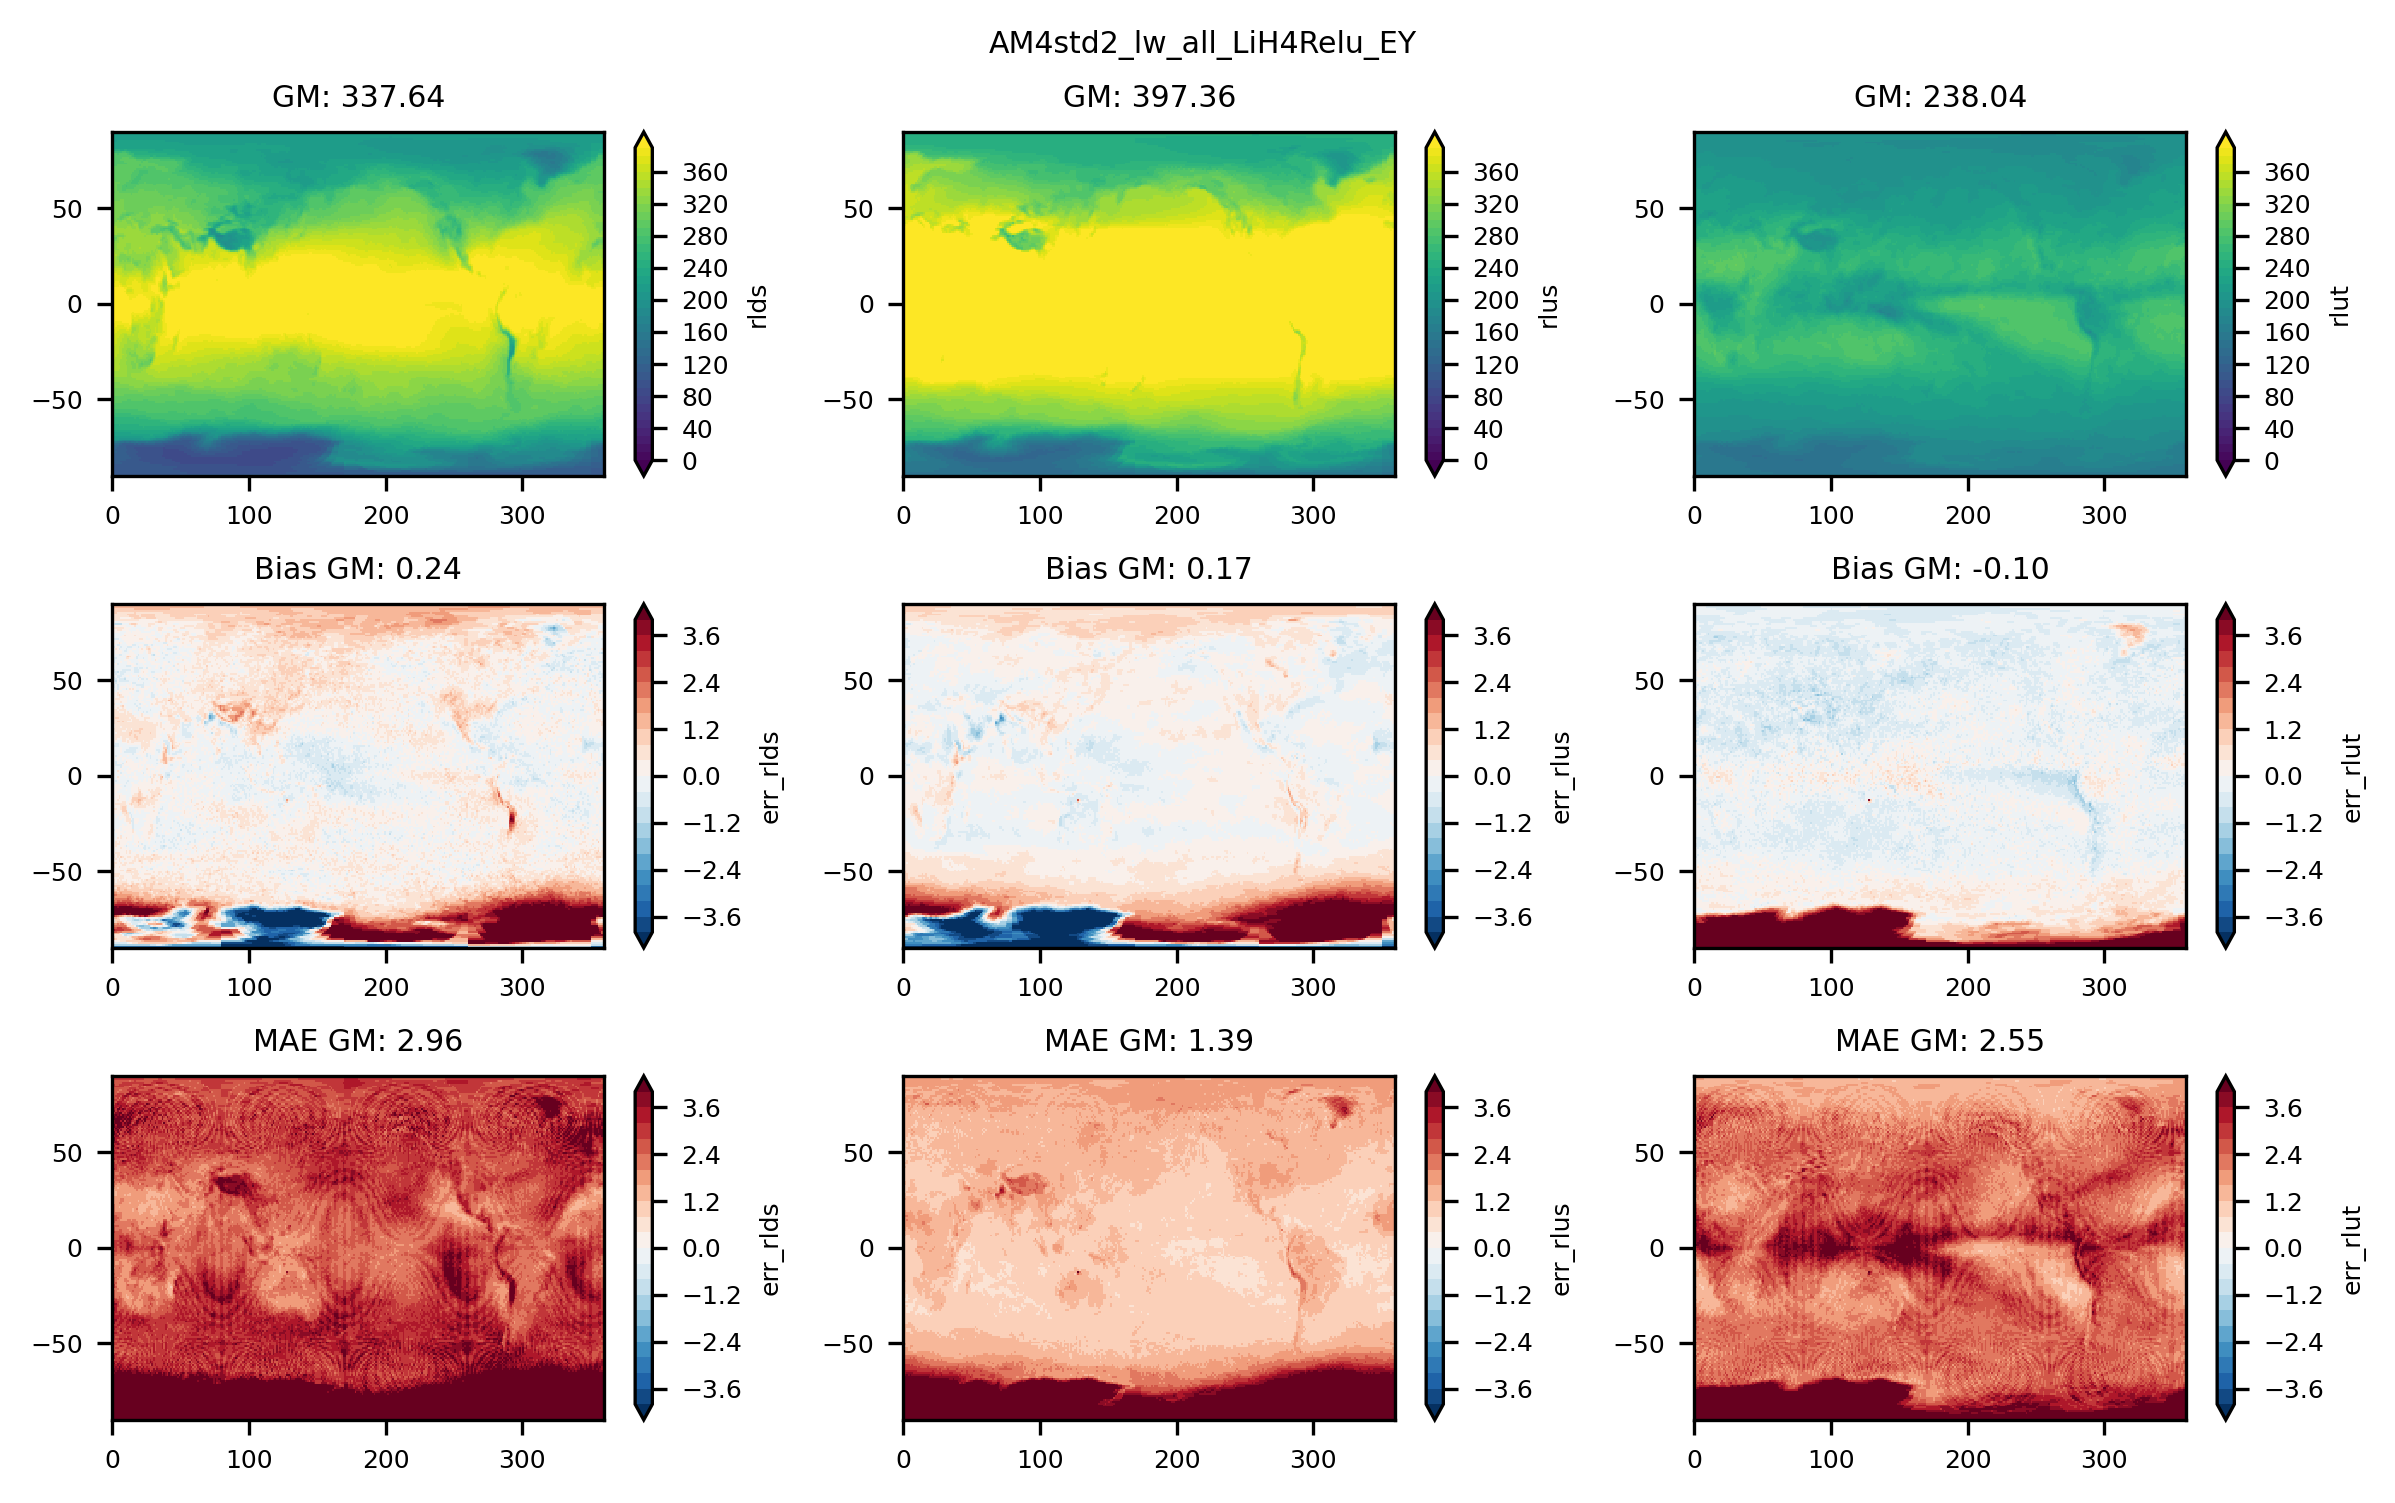

In [10]:
for mo in Exp_name:
    # mo = 'lw_af_Li5Relu_EY'
    time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
    ds_plot = ds_regrid[mo].isel(time=time_sel)
    fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(8,5),dpi=300)
    axs = axs.flatten()
    var1 = ['rlds','rlus','rlut']
    level = np.arange(0,400,10)
    for i in range(3):
        ax=axs[i]
        da = ds_plot[var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'GM: {global_mean_xarray(da).values:4.2f}') 
    level = np.array([-16, -8, -4,-2,-1,-0.5,-0.2,0,0.2,0.5,1,2,4,8,16])
    # level = np.array([ 0,0.2,0.5,1,2,4,8,16])
    level = np.arange(-5,5.1,0.5)/5
    if sky_cond[mo] == 'all':  level = level*4
    for i in range(3):
        ax=axs[i+3]
        da = ds_plot['err_'+var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both', )   
        ax.set_title(f'Bias GM: {global_mean_xarray(da).values:4.2f}')
                     # +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}')
    for i in range(3):
        ax=axs[i+6]
        da = abs(ds_plot['err_'+var1[i]]).mean('time') 
        da.plot(ax=ax, levels=level, extend='both', )    
        ax.set_title(f'MAE GM: {global_mean_xarray(da).values:4.2f}')
                     # +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    plt.suptitle(mo)
    fig.tight_layout()
    # break

In [11]:
print('GM: Bias, MAE, RMSE')
for mo in Exp_name:
    print(mo)
    ds_plot = ds_regrid[mo]
    for i in range(3): 
        da = global_mean_xarray(ds_plot['err_'+var1[i]])
        Bias = da.mean()
        MAE  = abs(da).mean()
        RMSE = ((da**2).mean())**0.5
        print(f'err_{var1[i]}: {Bias.values:4.2f}, {MAE.values:4.2f}, {RMSE.values:4.2f},') 

GM: Bias, MAE, RMSE
AM4std2_lw_cs_LiH4Relu_EN
err_rlds: 0.18, 0.18, 0.21,
err_rlus: 0.24, 0.25, 0.31,
err_rlut: 0.13, 0.17, 0.19,
AM4std2_lw_cs_LiH4Relu_EY
err_rlds: 0.10, 0.18, 0.23,
err_rlus: 0.10, 0.20, 0.23,
err_rlut: 0.16, 0.17, 0.21,
AM4std2_lw_all_LiH4Relu_EN
err_rlds: 0.10, 0.15, 0.19,
err_rlus: 0.00, 0.11, 0.16,
err_rlut: -0.12, 0.13, 0.16,
AM4std2_lw_all_LiH4Relu_EY
err_rlds: 0.24, 0.25, 0.33,
err_rlus: 0.17, 0.20, 0.27,
err_rlut: -0.10, 0.11, 0.13,


In [12]:
z_lev = [ 1.      ,    4.      ,    8.186021,   13.788865,   20.917952,
         29.836408,   41.217896,   55.792215,   74.201906,   97.047864,
        124.966648,  158.549553,  198.396959,  245.027221,  298.888576,
        360.040179,  427.458025,  498.243573,  568.220535,  633.836047,
        693.266329,  745.991986,  792.097373,  831.921945,  865.977814,
        894.872525,  919.22792 ,  939.565932,  956.402132,  970.147661,
        981.130665,  989.68    ,  995.9     ,  1000.     ]

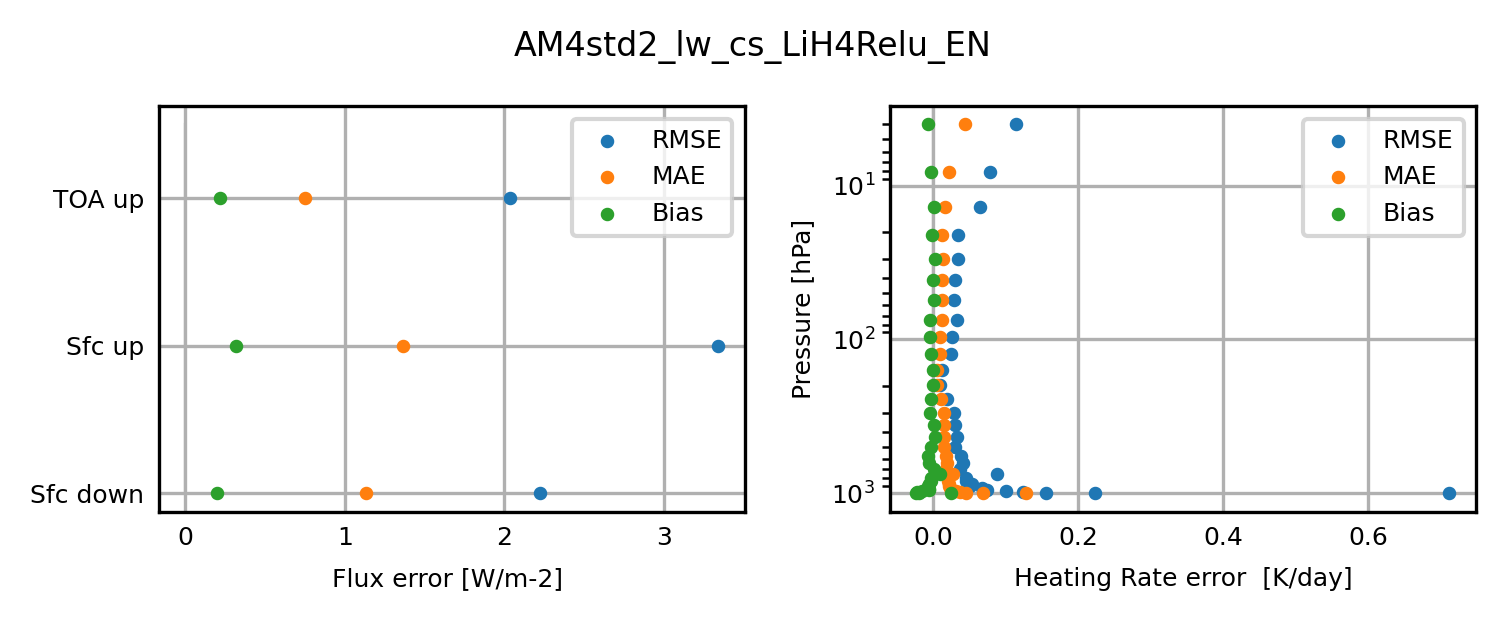

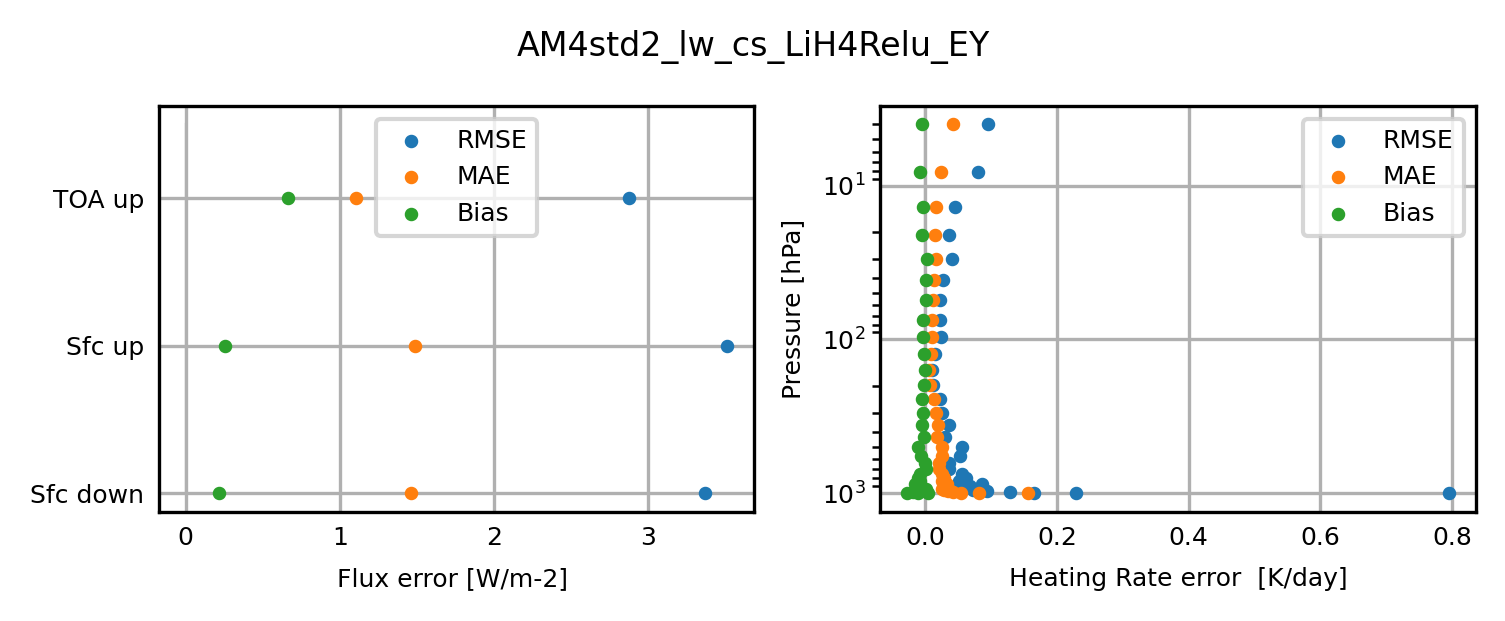

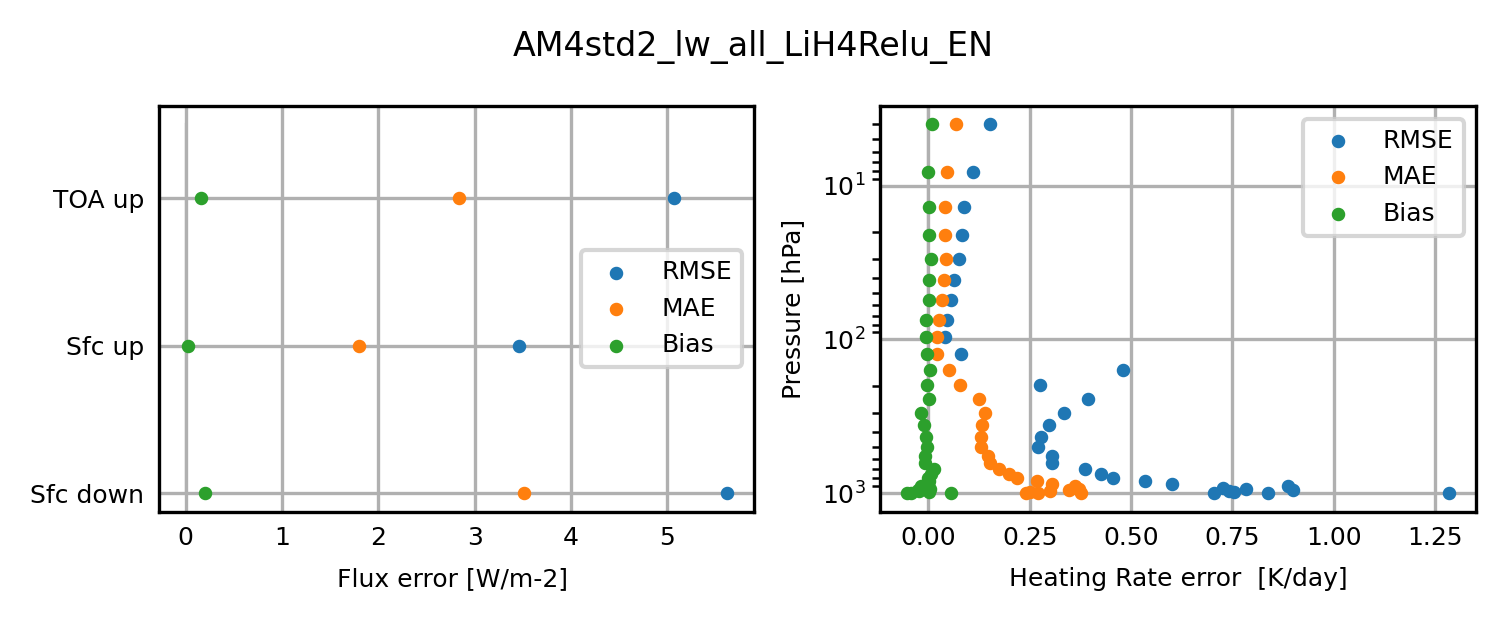

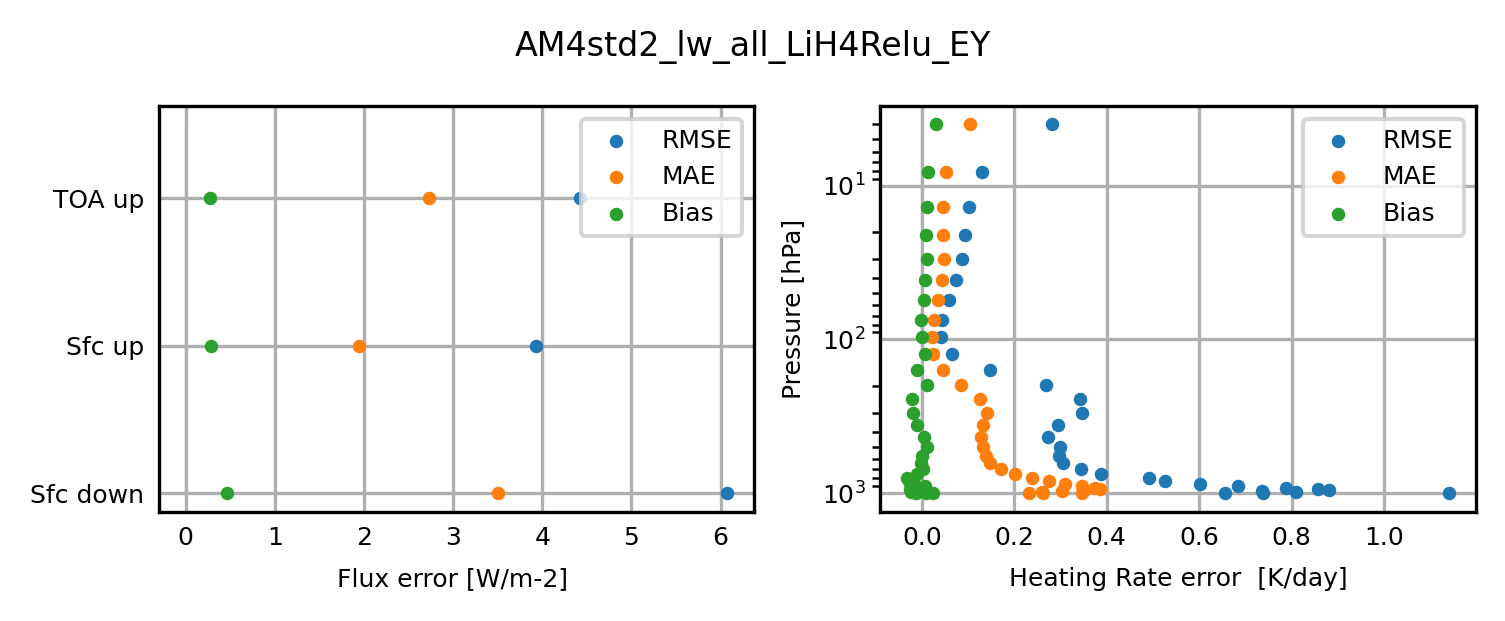

In [13]:
error = {}
day_inds = {} 
for i, mo in enumerate(Exp_name):
    ds = ds_regrid[mo]
    
    err_var = [ 'err_rlds','err_rlus','err_rlut','err_tntrl' ] 
    err = [ds[_].stack(txy=("time","lat", "lon")).values[None,:] for _ in err_var[:3]]
    err.append(ds[err_var[3]].stack(txy=("time","lat", "lon")).values)
    error[mo] = np.concatenate(err).T
    RMSE = ((error[mo]**2).mean(axis=0))**0.5
    MAE  = abs(error[mo]).mean(axis=0)
    bias = error[mo].mean(axis=0)
    plt.style.use('_mpl-gallery')
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5,2),dpi=300) 
    axs=axs.flatten() 
    ax3=axs[0] # error
    ax4=axs[1] # error 


    ax3.scatter(RMSE[:3], np.arange(3),  s=5, label='RMSE')
    ax3.scatter(MAE [:3], np.arange(3),  s=5, label='MAE')
    ax3.scatter(bias[:3], np.arange(3),  s=5, label='Bias')
    ax3.plot([0,0],[0,2.5],c='k',linewidth = 0.5, zorder=0)
    ax3.set_yticks([0,1,2], labels=[ 'Sfc down','Sfc up','TOA up',])
    ax3.legend(fontsize=6)
    ax3.set_xlabel('Flux error [W/m-2] ')
#     ax3.set_xlim([-0.1,1.2])

    ax4.scatter(RMSE[3:]  , z_lev[1:],  s=5, label='RMSE')
    ax4.scatter(MAE [3:]  , z_lev[1:],  s=5, label='MAE') 
    ax4.scatter(bias[3:]  , z_lev[1:],  s=5, label='Bias')
    ax4.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
    ax4.legend(fontsize=6)
    ax4.invert_yaxis()
    ax4.set_yscale('log') 
#     ax4.set_xlim([-0.04,0.4])
    ax4.set_xlabel('Heating Rate error  [K/day]')
    ax4.set_ylabel('Pressure [hPa]')
    plt.suptitle(mo,fontsize=8)
    fig.tight_layout()
    fig.show()

In [14]:
# [eng_err[mo].mean() for mo in Exp_name]

## exclude large energe error columns

In [15]:
for i, mo in enumerate(Exp_name): 
    time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
    ds_data = ds_regrid[mo].isel(time=time_sel)
    err_eng_arr = ds_data['err_eng'].values.flatten()
    ind_small_eng_err = np.argwhere(abs(err_eng_arr)<2)
    print(f"{mo} good ratio: {ind_small_eng_err.size/err_eng_arr.size:4.2f}")
    rd_id_more = np.random.randint(0,ind_small_eng_err.shape[0],1000000) 
    ind_small_eng_err = ind_small_eng_err[rd_id_more] 
    err_var_arr = np.stack([ds_data['err_rlds'].values.flatten(),
                            ds_data['err_rlus'].values.flatten(),
                            ds_data['err_rlut'].values.flatten()])
    RMSE = ((err_var_arr[:,ind_small_eng_err]**2).mean(axis=1))**0.5
    MAE  = abs(err_var_arr[:,ind_small_eng_err]).mean(axis=1)
    bias = err_var_arr[:,ind_small_eng_err].mean(axis=1) 
    print(RMSE[:3],MAE[:3],bias[:3])
    rd_id_more = np.random.randint(0,err_eng_arr.shape[0],1000000) 
    RMSE = ((err_var_arr[:,rd_id_more]**2).mean(axis=1))**0.5
    MAE  = abs(err_var_arr[:,rd_id_more]).mean(axis=1)
    bias = err_var_arr[:,rd_id_more].mean(axis=1)
    print(RMSE[:3],MAE[:3],bias[:3])

AM4std2_lw_cs_LiH4Relu_EN good ratio: 0.91
[[1.5872014]
 [2.21701  ]
 [1.254399 ]] [[0.9153886]
 [1.0273324]
 [0.5677295]] [[0.26244113]
 [0.30297932]
 [0.201406  ]]
[2.204453  3.3191822 2.0137682] [1.1300609 1.3591667 0.7455502] [0.1927266  0.31481412 0.213333  ]
AM4std2_lw_cs_LiH4Relu_EY good ratio: 0.96
[[2.1318486]
 [2.293528 ]
 [1.3226004]] [[1.0535915 ]
 [1.066478  ]
 [0.66521966]] [[-0.08515025]
 [-0.03551292]
 [ 0.20639887]]
[3.3675    3.5072148 2.8725672] [1.4610697 1.4865111 1.1061817] [0.21567139 0.25103363 0.66427207]
AM4std2_lw_all_LiH4Relu_EN good ratio: 0.77
[[4.2066717]
 [1.9149292]
 [3.843788 ]] [[2.9259634]
 [1.2264178]
 [2.4422522]] [[ 0.05139268]
 [-0.0058761 ]
 [-0.14348334]]
[5.5656343 3.405687  5.085006 ] [3.5162468 1.8046473 2.8420658] [0.20008428 0.02484763 0.16195518]
AM4std2_lw_all_LiH4Relu_EY good ratio: 0.98
[[4.881222 ]
 [2.9955773]
 [3.6535053]] [[3.2181811]
 [1.6819931]
 [2.444764 ]] [[ 0.35630035]
 [ 0.30548024]
 [-0.06529705]]
[6.061903  3.9103556 4.37

# energy check

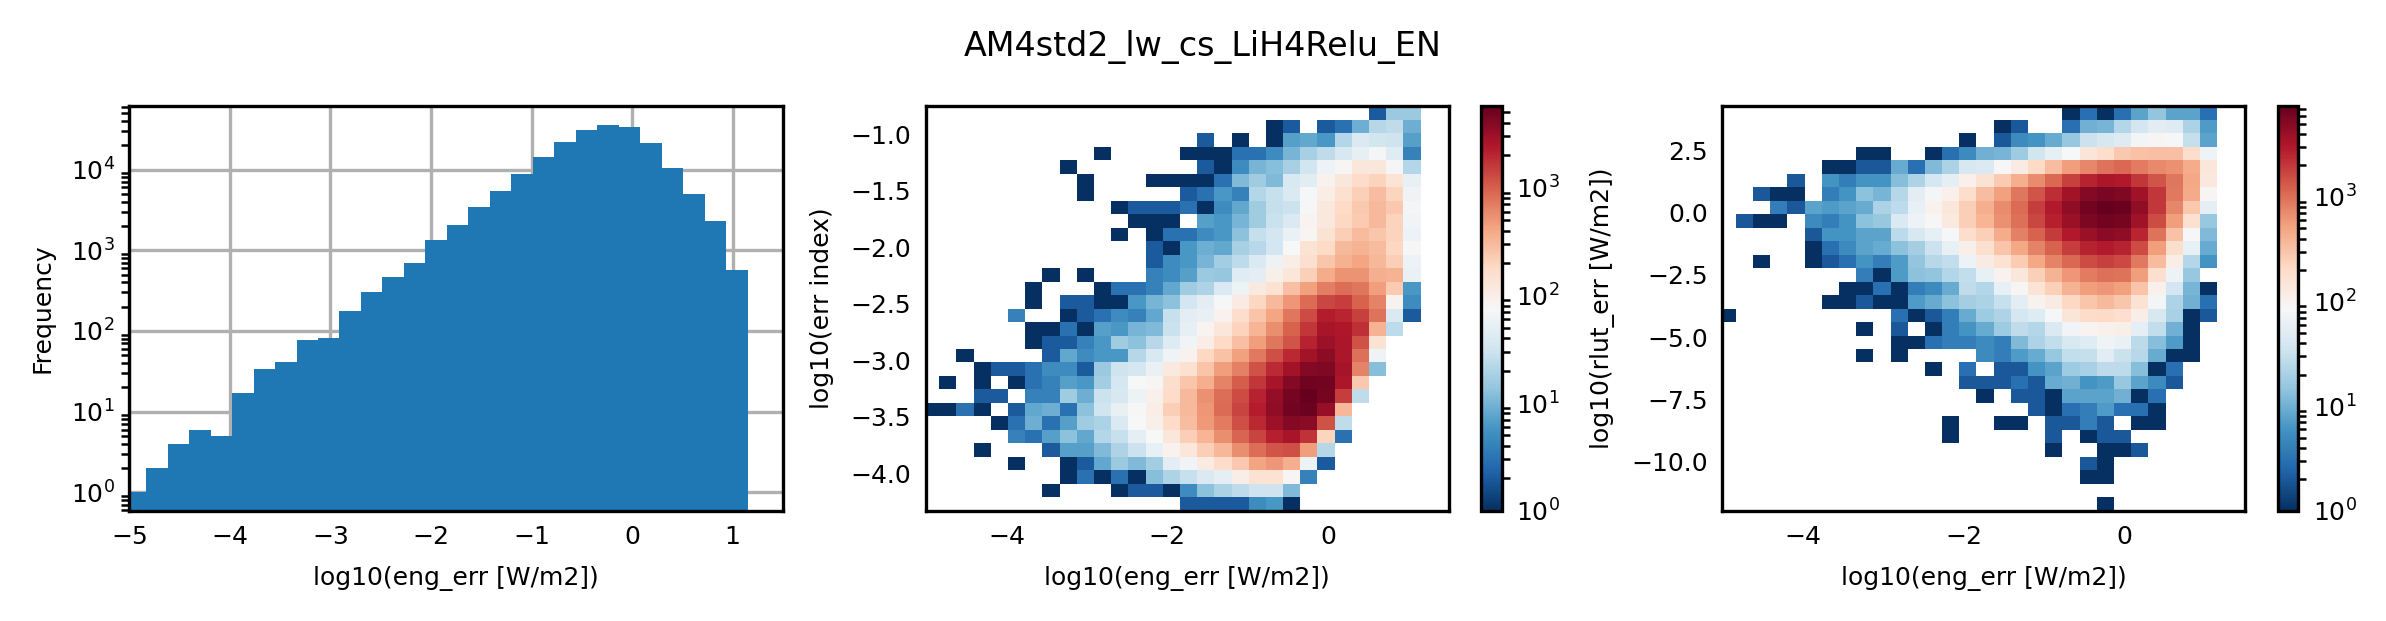

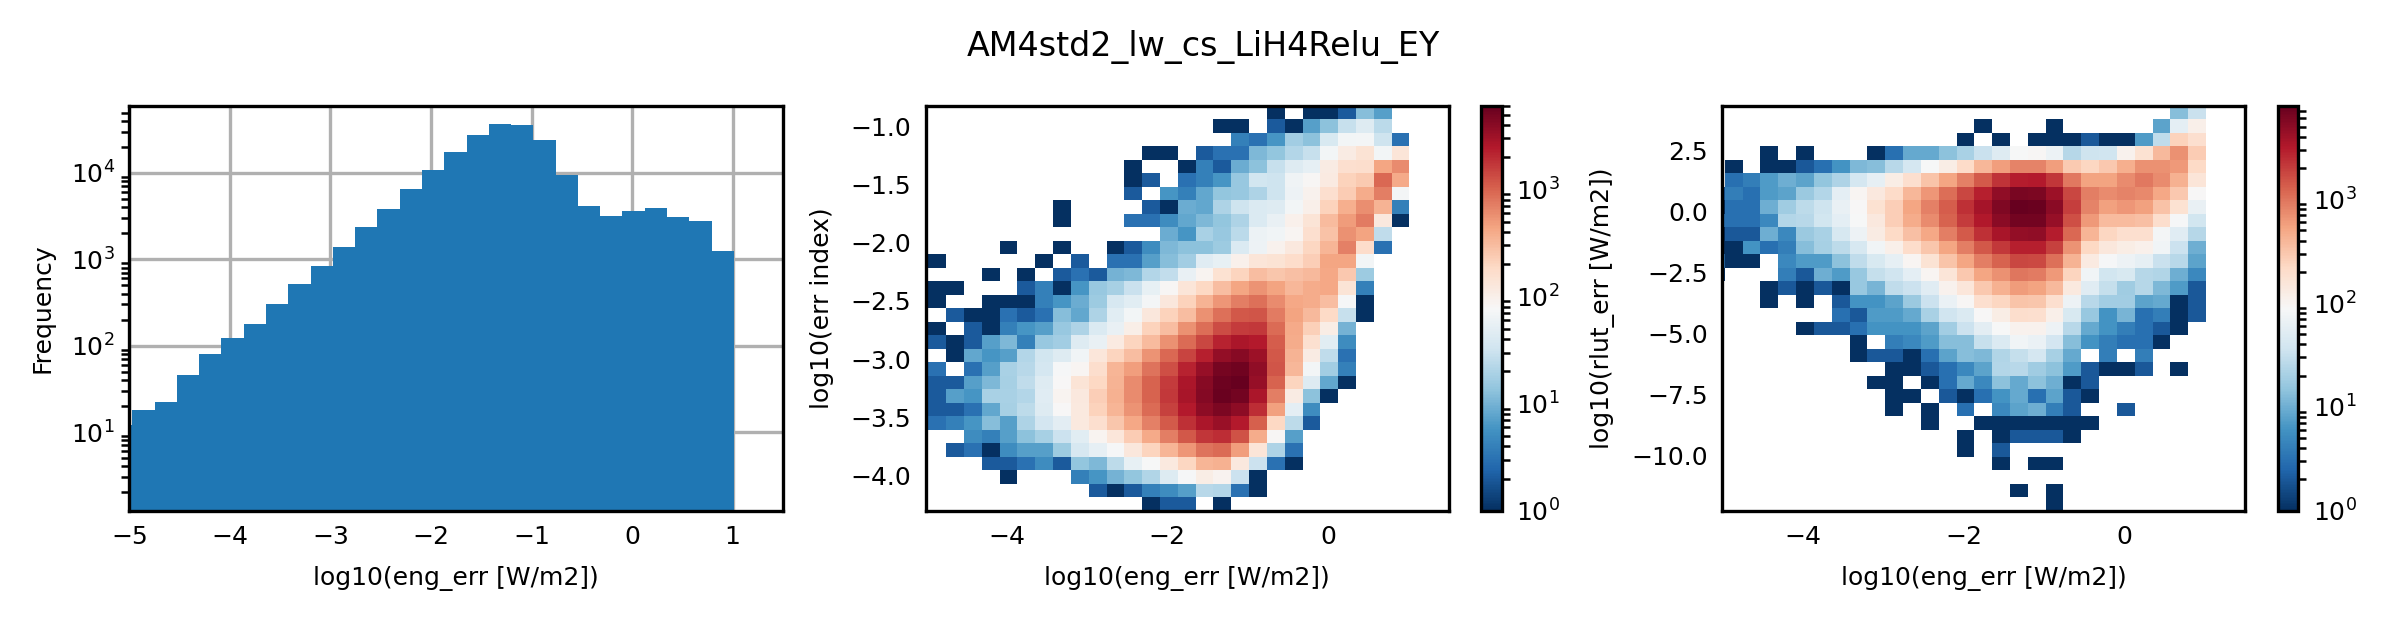

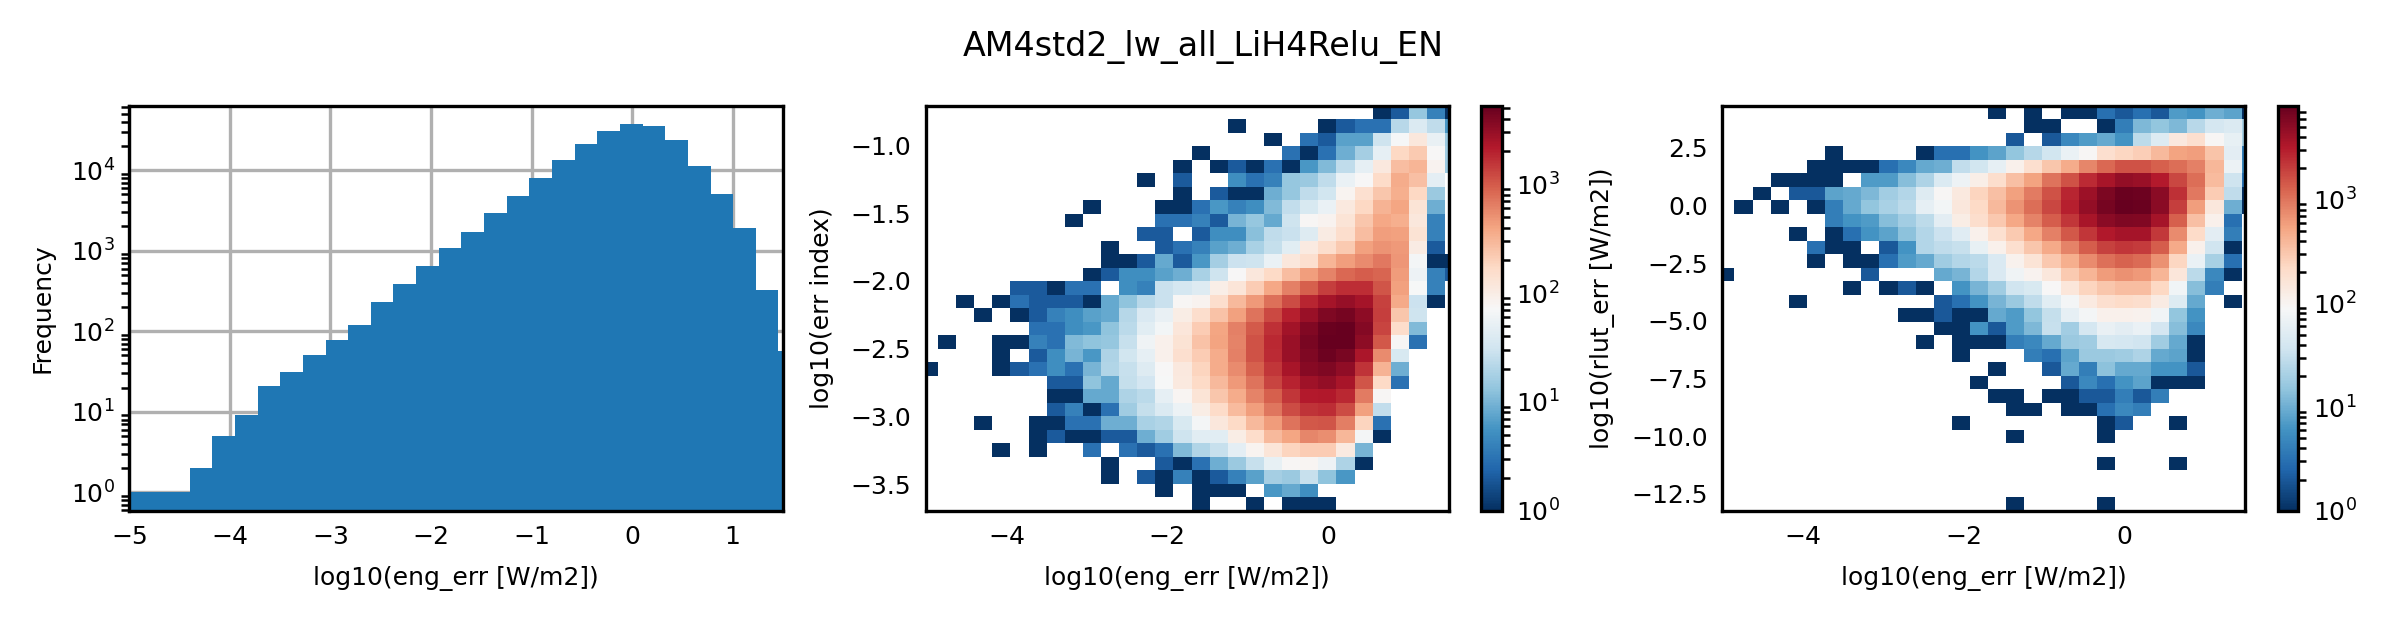

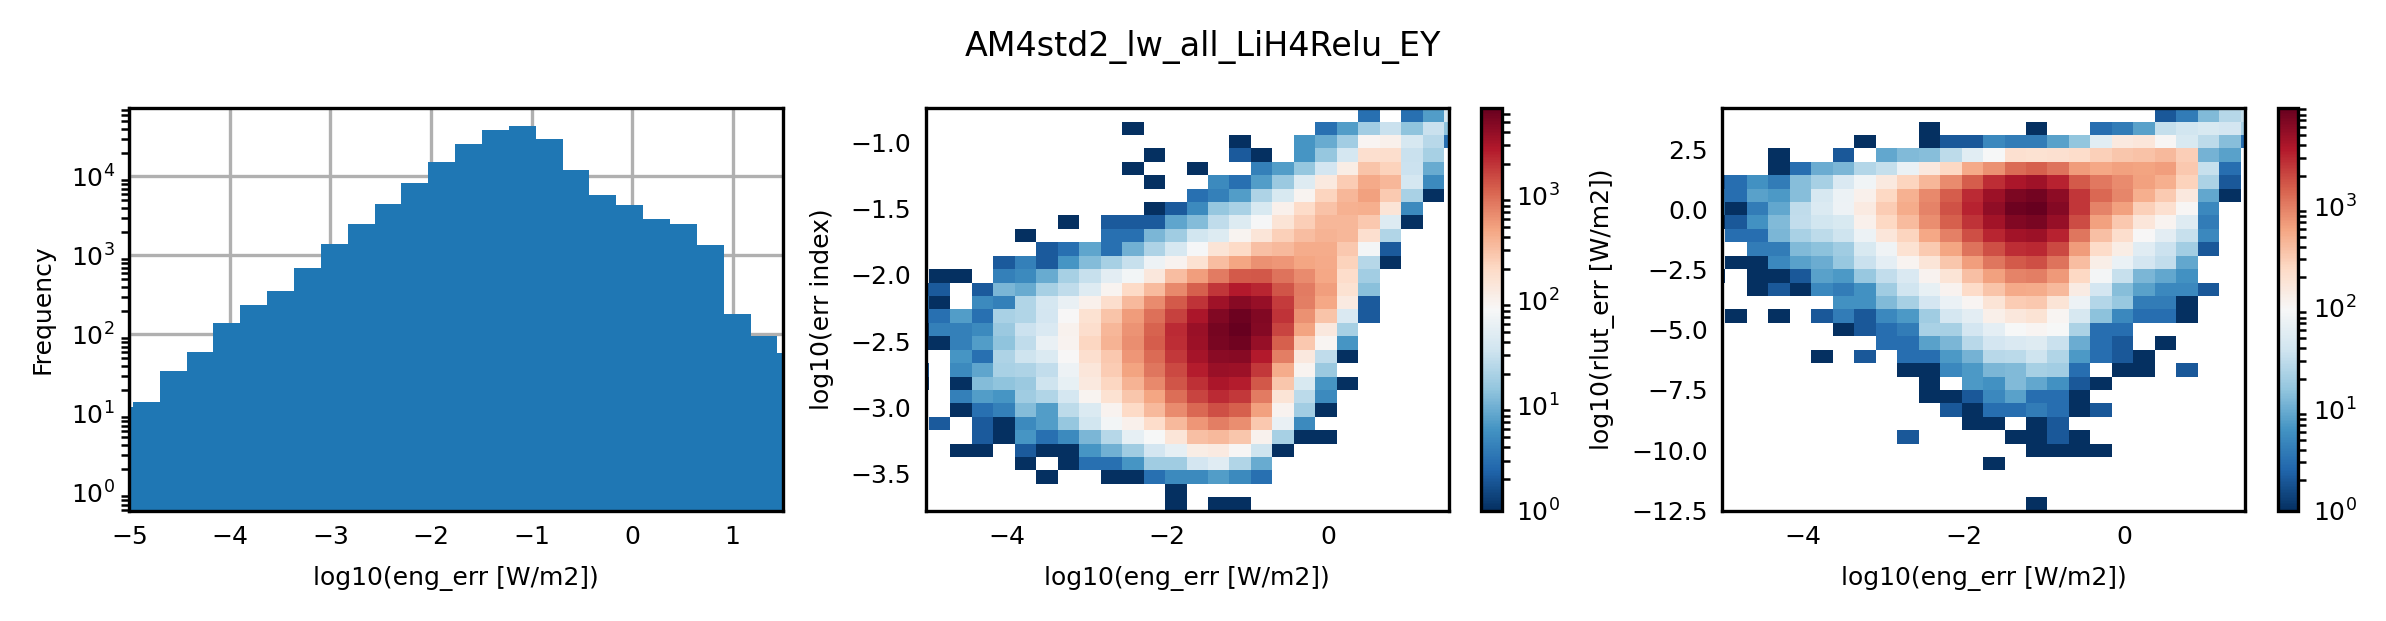

In [16]:
var_arr = {}
for i, mo in enumerate(Exp_name):  
    time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
    ds_data = ds_regrid[mo].isel(time=time_sel)
    err_eng_arr = ds_data['err_eng'].values.flatten()

    vars_var = [ 'rlut','rlus','rlds','tntrl' ] 
    var = [ds[_].stack(txy=("time","lat", "lon")).values[None,:] for _ in vars_var[:3]]
    var.append(ds[vars_var[3]].stack(txy=("time","lat", "lon")).values)
    var_arr[mo] = np.concatenate(var).T
    
    std_nor = var_arr[mo].std(axis=1)[:,None]
    pred_err_ind = abs(error[mo]/std_nor).mean(axis=1)
    rd_id_more = np.random.randint(0,err_eng_arr.size,200000)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,2),dpi=300, tight_layout=True) 
    axs= axs.flatten()
    ax = axs[0]
    eng_err_log = np.log(abs(err_eng_arr[rd_id_more])+1e-6)/np.log(10)
    pred_err_ind_log = np.log(abs(pred_err_ind[rd_id_more])+1e-6)/np.log(10)
    ax.hist(eng_err_log,bins=30)
    ax.set_yscale('log')
    ax.set_xlim([-5,1.5])
    ax.set_xlabel('log10(eng_err [W/m2])')
    ax.set_ylabel('Frequency')
    ax = axs[1]
    h=ax.hist2d(eng_err_log,pred_err_ind_log, bins=30,
                norm=colors.LogNorm(),
                cmap='RdBu_r') 
    fig.colorbar(h[3], ax=ax)
    ax.set_xlim([-5,1.5])
    ax.set_xlabel('log10(eng_err [W/m2])')
    ax.set_ylabel('log10(err index)')
    ax = axs[2]
    h=ax.hist2d(eng_err_log,np.log(abs(err_var_arr[0,rd_id_more]+1e-6)/np.log(10)),
               bins=30, 
                norm=colors.LogNorm(),
                cmap='RdBu_r') 
    fig.colorbar(h[3], ax=ax)
    ax.set_xlim([-5,1.5])
    ax.set_xlabel('log10(eng_err [W/m2])')
    ax.set_ylabel('log10(rlut_err [W/m2])')
    plt.suptitle(mo,fontsize=8) 
    fig.show()

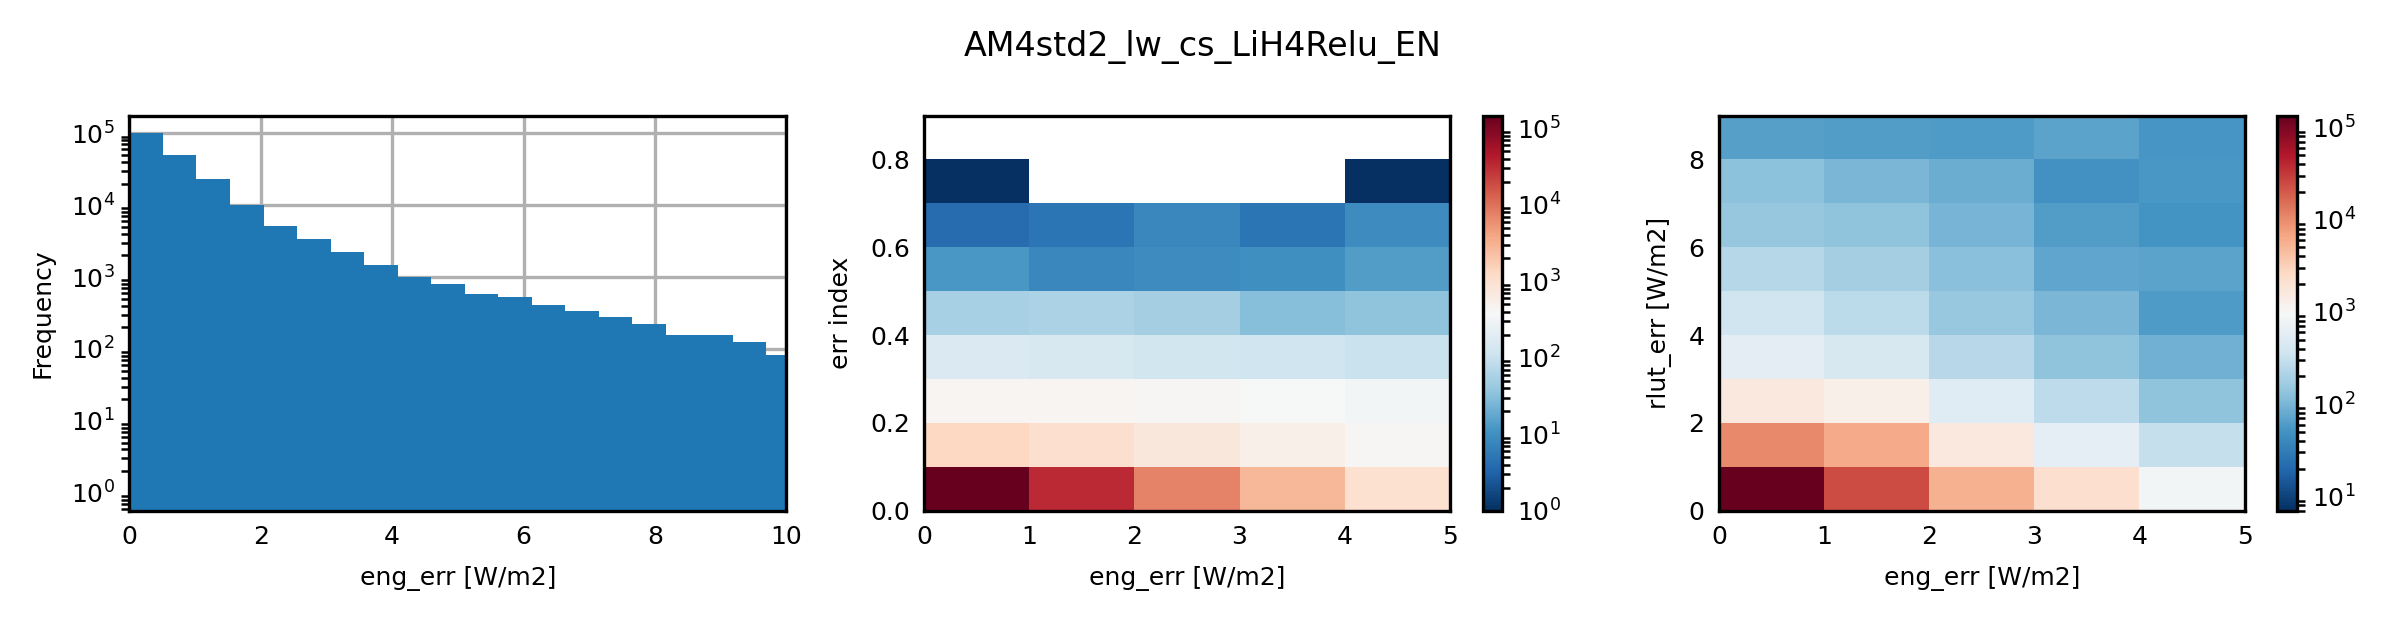

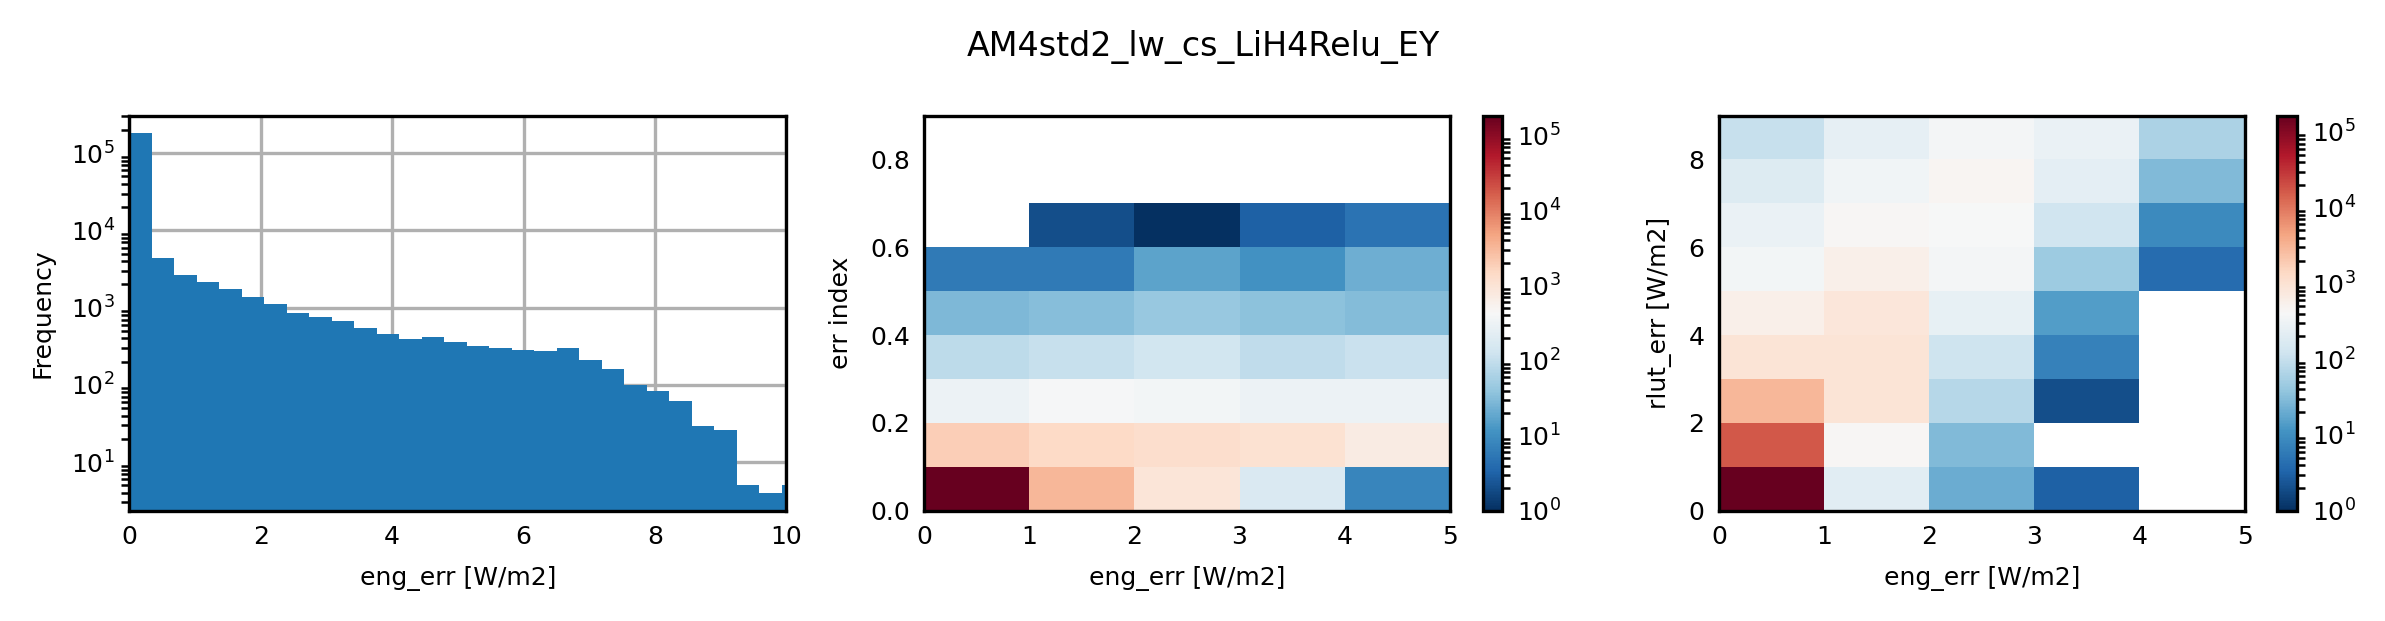

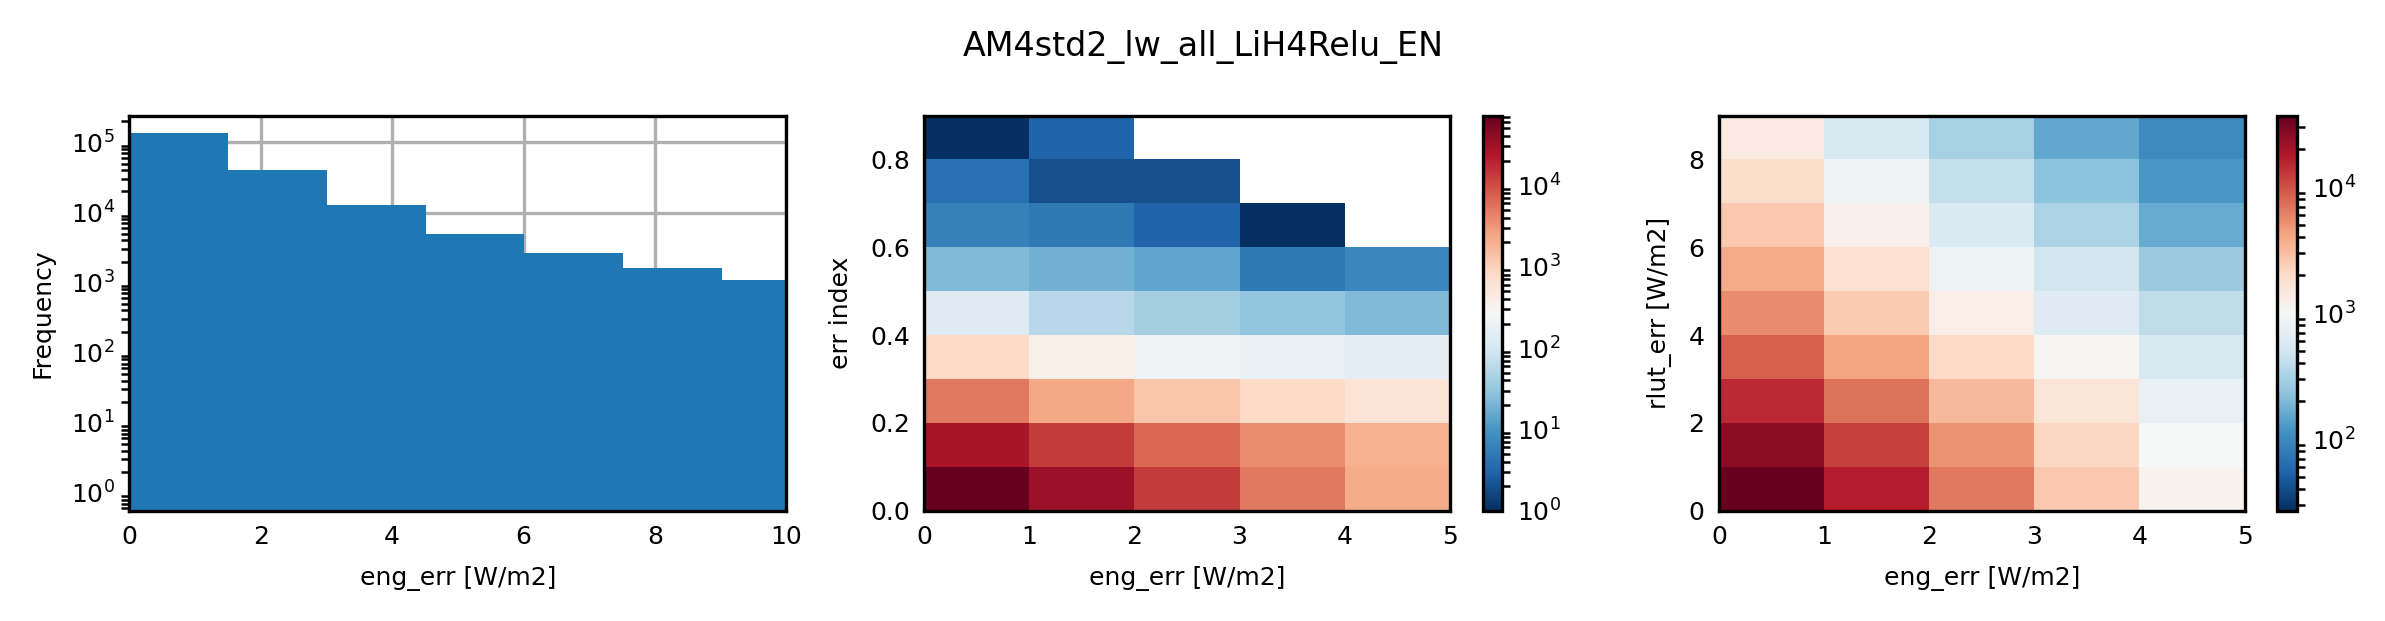

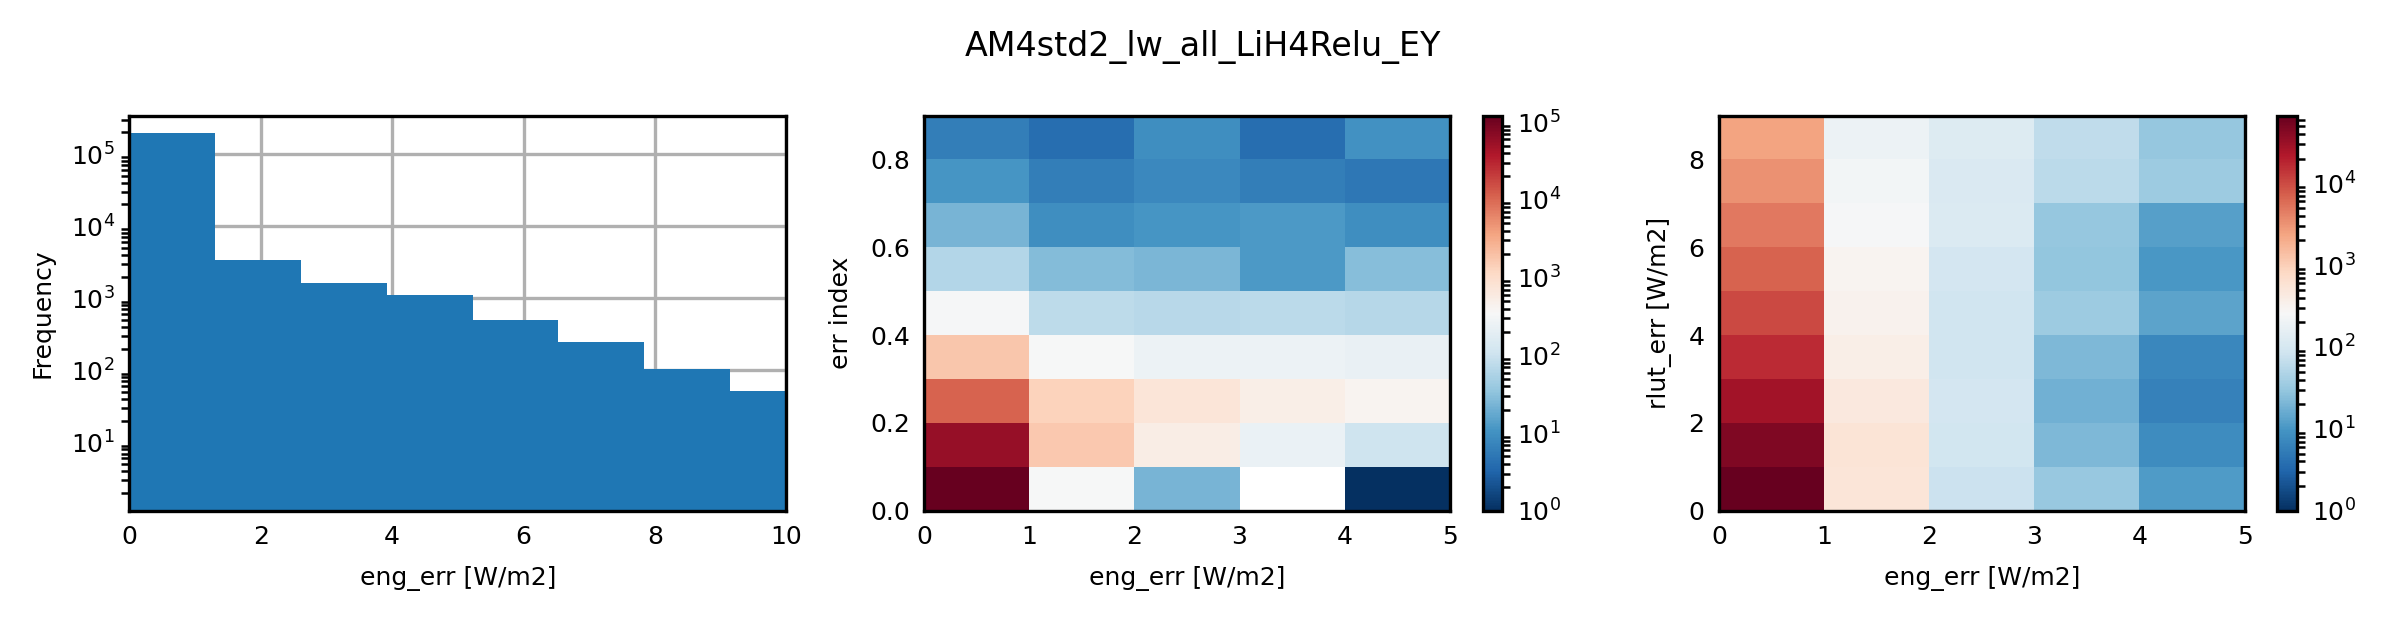

In [17]:
for i, mo in enumerate(Exp_name):  
    time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
    ds_data = ds_regrid[mo].isel(time=time_sel)
    err_eng_arr = ds_data['err_eng'].values.flatten()

    err_var_arr = np.concatenate([ds_data['err_rlut'].values.reshape(-1,err_eng_arr.size),
                                  ds_data['err_rlus'].values.reshape(-1,err_eng_arr.size),
                                  ds_data['err_rlds'].values.reshape(-1,err_eng_arr.size),
                                  ds_data['err_tntrl'].stack(tll=['time','lat','lon']).values])
    var_arr = np.concatenate([ds_data['rlut'].values.reshape(-1,err_eng_arr.size),
                              ds_data['rlus'].values.reshape(-1,err_eng_arr.size),
                              ds_data['rlds'].values.reshape(-1,err_eng_arr.size),
                              ds_data['tntrl'].stack(tll=['time','lat','lon']).values])
    std_nor = var_arr.std(axis=1)[:,None]
    pred_err_ind = abs(err_var_arr/std_nor).mean(axis=0)
    rd_id_more = np.random.randint(0,err_eng_arr.size,200000)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,2),dpi=300, tight_layout=True) 
    axs= axs.flatten()
    ax = axs[0]
    # eng_err_log = np.log(abs(err_eng_arr[rd_id_more])+1e-6)/np.log(10)
    # pred_err_ind_log = np.log(abs(pred_err_ind[rd_id_more])+1e-6)/np.log(10)
    eng_err_log = abs(err_eng_arr[rd_id_more])
    pred_err_ind_log = abs(pred_err_ind[rd_id_more])
    ax.hist(eng_err_log,bins=30)
    ax.set_yscale('log')
    # ax.set_xlim([-5,1.5])
    ax.set_xlim([0,10])
    ax.set_xlabel('eng_err [W/m2]')
    ax.set_ylabel('Frequency')
    ax = axs[1]
    h=ax.hist2d(eng_err_log,pred_err_ind_log, 
                bins=[np.arange(0,10,1),np.arange(0,1,0.1)], 
                norm=colors.LogNorm(),
                cmap='RdBu_r') 
    fig.colorbar(h[3], ax=ax)
    # ax.set_xlim([-5,1.5])
    ax.set_xlim([0,5])
    ax.set_xlabel('eng_err [W/m2]')
    ax.set_ylabel('err index')
    ax = axs[2]
    h=ax.hist2d(eng_err_log,abs(err_var_arr[0,rd_id_more]),
                bins=[np.arange(0,10,1),np.arange(0,10,1)], 
                norm=colors.LogNorm(),
                cmap='RdBu_r') 
    fig.colorbar(h[3], ax=ax)
    # ax.set_xlim([-5,1.5])
    ax.set_xlim([0,5])
    ax.set_xlabel('eng_err [W/m2]')
    ax.set_ylabel('rlut_err [W/m2]')
    plt.suptitle(mo,fontsize=8) 
    fig.show()